# *Imports*

In [10]:
import pandas as pd
import numpy as np
#import catboost as cb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
#import tensorflow as tf
#from gradient_free_optimizers import EvolutionStrategyOptimizer
from functools import partial
import multiprocessing
from multiprocessing import Pool, active_children
import time
from scipy.stats import entropy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tqdm import tqdm
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from collections import defaultdict
from matplotlib import gridspec

#from catboost import CatBoostClassifier
#from art.estimators.classification import CatBoostARTClassifier
#from art.attacks.evasion import ZooAttack
#from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

# **Functions**

## Train target model

In [ ]:
def train_cat_model(df, feature_name, ext_size=0.2, test_size=0.5, rand_stat=42, iter=100, verbose=1):
    # Split data into train and test sets
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Replace NaN values in categorical features with an appropriate value
    for feature in cat_features:
        X[feature].fillna(value='Unknown', inplace=True)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=rand_stat)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train CatBoost model
    model = cb.CatBoostRegressor(iterations=iter, learning_rate=0.1, loss_function='RMSE')
    model.fit(X_train, y_train, cat_features=cat_features, verbose=0)

    # Make predictions and calculate accuracy
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    relative_train_rmse = train_rmse / np.mean(y_train)
    train_errors = y_train - train_preds

    if test_size > 0:
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        relative_test_rmse = test_rmse / np.mean(y_test)
        test_errors = y_test - test_preds
    else:
        test_preds = []
        test_rmse = np.nan
        relative_test_rmse = np.nan
        test_errors = []

    overfit_percentage = ((test_rmse - train_rmse) / train_rmse) * 100  # Percentage increase

    # Find the minimum and maximum values, ignoring NaNs
    min_value = np.nanmin(np.concatenate([train_errors, test_errors]))
    max_value = np.nanmax(np.concatenate([train_errors, test_errors]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Print metrics and plot prediction errors
    if verbose == 1:
        print(f"Train set: RMSE = {train_rmse:.4f}, Relative RMSE = {relative_train_rmse:.4f}")
        print(f"Test set: RMSE = {test_rmse:.4f}, Relative RMSE = {relative_test_rmse:.4f}")
        print(f"Overfit_percentage = {overfit_percentage:.4f}")
        plt.hist(train_errors, bins=bin_edges, alpha=0.5, label='Train')
        plt.hist(test_errors, bins=bin_edges, alpha=0.5, label='Test')
        plt.legend()
        plt.xlabel('Prediction error')
        plt.ylabel('Frequency')
        plt.show()

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_cat_wo_cat_model(df, feature_name, ext_size=0.2, test_size=0.5, verbose=1):
    # Split data into train and test sets
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Replace NaN values in categorical features with an appropriate value
    for feature in cat_features:
        X[feature].fillna(value='Unknown', inplace=True)

    # Drop categorical variables
    X = X.drop(columns=cat_features)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train CatBoost model
    model = cb.CatBoostRegressor(iterations=300, learning_rate=0.1, loss_function='RMSE')
    model.fit(X_train, y_train, cat_features=[], verbose=0)

    # Make predictions and calculate accuracy
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    relative_train_rmse = train_rmse / np.mean(y_train)
    train_errors = y_train - train_preds

    if test_size > 0:
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        relative_test_rmse = test_rmse / np.mean(y_test)
        test_errors = y_test - test_preds
    else:
        test_preds = []
        test_rmse = np.nan
        relative_test_rmse = np.nan
        test_errors = []

    overfit_percentage = ((test_rmse - train_rmse) / train_rmse) * 100  # Percentage increase

    # Find the minimum and maximum values, ignoring NaNs
    min_value = np.nanmin(np.concatenate([train_errors, test_errors]))
    max_value = np.nanmax(np.concatenate([train_errors, test_errors]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Print metrics and plot prediction errors
    if verbose == 1:
        print(f"Train set: RMSE = {train_rmse:.4f}, Relative RMSE = {relative_train_rmse:.4f}")
        print(f"Test set: RMSE = {test_rmse:.4f}, Relative RMSE = {relative_test_rmse:.4f}")
        print(f"Overfit_percentage = {overfit_percentage:.4f}")
        plt.hist(train_errors, bins=bin_edges, alpha=0.5, label='Train')
        plt.hist(test_errors, bins=bin_edges, alpha=0.5, label='Test')
        plt.legend()
        plt.xlabel('Prediction error')
        plt.ylabel('Frequency')
        plt.show()

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_linreg_model(df, feature_name, ext_size=0.2, test_size=0.5, verbose=1):
    # Fill NaN values with the mean of each column
    df.fillna(df.mean(), inplace=True)

    # Split the data to features and target variable
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Drop categorical variables
    X = X.drop(columns=cat_features)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    relative_train_rmse = train_rmse / np.mean(y_train)
    train_errors = y_train - train_preds

    if test_size > 0:
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        relative_test_rmse = test_rmse / np.mean(y_test)
        test_errors = y_test - test_preds
    else:
        test_preds = []
        test_rmse = np.nan
        relative_test_rmse = np.nan
        test_errors = []

    overfit_percentage = ((test_rmse - train_rmse) / train_rmse) * 100  # Percentage increase

    # Find the minimum and maximum values, ignoring NaNs
    min_value = -100000 #np.nanmin(np.concatenate([train_errors, test_errors]))
    max_value = 100000 #np.nanmax(np.concatenate([train_errors, test_errors]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Print metrics and plot prediction errors
    if verbose == 1:
        print(f"Train set: RMSE = {train_rmse:.4f}, Relative RMSE = {relative_train_rmse:.4f}")
        print(f"Test set: RMSE = {test_rmse:.4f}, Relative RMSE = {relative_test_rmse:.4f}")
        print(f"Overfit_percentage = {overfit_percentage:.4f}")
        plt.hist(train_errors, bins=bin_edges, alpha=0.5, label='Train')
        plt.hist(test_errors, bins=bin_edges, alpha=0.5, label='Test')
        plt.legend()
        plt.xlabel('Prediction error')
        plt.ylabel('Frequency')
        plt.show()

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_XGB_model(df, feature_name, ext_size=0.2, test_size=0.5, rand_stat=42, n_est=100, max_d=5, verbose=1):
    # Split the data to features and target variable
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Drop categorical variables
    X = X.drop(columns=cat_features)

    # Fill NaN values with the mean of each column
    X.fillna(X.mean(), inplace=True)
    y.fillna(y.mean(), inplace=True)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=rand_stat)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train Linear Regression model
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = max_d, alpha = 10, n_estimators = n_est)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    relative_train_rmse = train_rmse / np.mean(y_train)
    train_errors = y_train - train_preds

    if test_size > 0:
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        relative_test_rmse = test_rmse / np.mean(y_test)
        test_errors = y_test - test_preds
    else:
        test_preds = []
        test_rmse = np.nan
        relative_test_rmse = np.nan
        test_errors = []

    overfit_percentage = ((test_rmse - train_rmse) / train_rmse) * 100  # Percentage increase

    # Find the minimum and maximum values, ignoring NaNs
    min_value = np.nanmin(np.concatenate([train_errors, test_errors]))
    max_value = np.nanmax(np.concatenate([train_errors, test_errors]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Print metrics and plot prediction errors
    if verbose == 1:
        print(f"Train set: RMSE = {train_rmse:.4f}, Relative RMSE = {relative_train_rmse:.4f}")
        print(f"Test set: RMSE = {test_rmse:.4f}, Relative RMSE = {relative_test_rmse:.4f}")
        print(f"R2 Score = {model.score(X_test, y_test):.4f}")
        print(f"Overfit_percentage = {overfit_percentage:.4f}")
        plt.hist(train_errors, bins=bin_edges, alpha=0.5, label='Train')
        plt.hist(test_errors, bins=bin_edges, alpha=0.5, label='Test')
        plt.legend()
        plt.xlabel('Prediction error')
        plt.ylabel('Frequency')
        plt.show()

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_DT_model(df, feature_name, ext_size=0.2, test_size=0.5, verbose=1):
    # Fill NaN values with the mean of each column
    df.fillna(df.mean(), inplace=True)

    # Split the data to features and target variable
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Drop categorical variables
    X = X.drop(columns=cat_features)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train Linear Regression model
    model = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    relative_train_rmse = train_rmse / np.mean(y_train)
    train_errors = y_train - train_preds

    if test_size > 0:
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        relative_test_rmse = test_rmse / np.mean(y_test)
        test_errors = y_test - test_preds
    else:
        test_preds = []
        test_rmse = np.nan
        relative_test_rmse = np.nan
        test_errors = []

    overfit_percentage = ((test_rmse - train_rmse) / train_rmse) * 100  # Percentage increase

    # Find the minimum and maximum values, ignoring NaNs
    min_value = -100000 #np.nanmin(np.concatenate([train_errors, test_errors]))
    max_value = 100000 #np.nanmax(np.concatenate([train_errors, test_errors]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Print metrics and plot prediction errors
    if verbose == 1:
        print(f"Train set: RMSE = {train_rmse:.4f}, Relative RMSE = {relative_train_rmse:.4f}")
        print(f"Test set: RMSE = {test_rmse:.4f}, Relative RMSE = {relative_test_rmse:.4f}")
        print(f"Overfit_percentage = {overfit_percentage:.4f}")
        plt.hist(train_errors, bins=bin_edges, alpha=0.5, label='Train')
        plt.hist(test_errors, bins=bin_edges, alpha=0.5, label='Test')
        plt.legend()
        plt.xlabel('Prediction error')
        plt.ylabel('Frequency')
        plt.show()

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_RF_model(df, feature_name, ext_size=0.2, test_size=0.5, n_est=100, rand_stat=42, max_d=5, bootstrap_val=True, verbose=1):
    # Fill NaN values with the mean of each column
    numeric_df = df.select_dtypes(include=['number'])
    numeric_df.fillna(numeric_df.mean(), inplace=True)

    for col in numeric_df.columns:
        df[col] = numeric_df[col]

    # Split the data to features and target variable
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Drop categorical variables
    X = X.drop(columns=cat_features)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=rand_stat)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train Linear Regression model
    # model = RandomForestRegressor(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5, oob_score=True) experiment 1
    model = RandomForestRegressor(n_estimators=n_est, random_state=rand_stat, max_depth=max_d, min_samples_split=10, min_samples_leaf=5, oob_score=True, bootstrap=bootstrap_val)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    relative_train_rmse = train_rmse / np.mean(y_train)
    train_errors = y_train - train_preds

    if test_size > 0:
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        relative_test_rmse = test_rmse / np.mean(y_test)
        test_errors = y_test - test_preds
        r_squared = model.score(X_test, y_test)
    else:
        test_preds = []
        test_rmse = np.nan
        relative_test_rmse = np.nan
        test_errors = []
        r_squared = 0

    overfit_percentage = ((test_rmse - train_rmse) / train_rmse) * 100  # Percentage increase

    # Find the minimum and maximum values, ignoring NaNs
    min_value = np.nanmin(np.concatenate([train_errors, test_errors]))
    max_value = np.nanmax(np.concatenate([train_errors, test_errors]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Print metrics and plot prediction errors
    if verbose == 1:
        print(f"Train set: RMSE = {train_rmse:.4f}, Relative RMSE = {relative_train_rmse:.4f}")
        print(f"Test set: RMSE = {test_rmse:.4f}, Relative RMSE = {relative_test_rmse:.4f}")
        print(f"Test R2 score = {r_squared:.4f}")
        print(f"Overfit_percentage = {overfit_percentage:.4f}")
        plt.hist(train_errors, bins=bin_edges, alpha=0.5, label='Train')
        plt.hist(test_errors, bins=bin_edges, alpha=0.5, label='Test')
        plt.legend()
        plt.xlabel('Prediction error')
        plt.ylabel('Frequency')
        plt.show()

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_clas_model(df, feature_name, ext_size=0.5, test_size=0.5, verbose=1, num_classes=100):
    # Split data into train and test sets
    X = df.drop(columns=[feature_name])
    y = df[feature_name]

    # Calculate the bin edges based on the number of classes
    bin_edges = np.linspace(min(y), max(y), num_classes + 1)

    # Perform binning to transform the house prices into classes
    y = np.digitize(y, bin_edges) - 1

    # Identify categorical features automatically
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    # Replace NaN values in categorical features with an appropriate value
    for feature in cat_features:
        X[feature].fillna(value='Unknown', inplace=True)

    # Split data into original and external sets
    if ext_size > 0:
        X_orig, X_ext, y_orig, y_ext = train_test_split(X, y, test_size=ext_size, random_state=42)
    else:
        X_orig, X_ext, y_orig, y_ext = X, [], y, []

    # Split data into train and test sets
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = X, [], y, []

    # Train CatBoost model
    model = cb.CatBoostClassifier(custom_loss=['Accuracy'], random_seed=42, logging_level='Silent')
    model.fit(X_train, y_train, cat_features=cat_features, verbose=0)

    if verbose == 1:

        train_y_true = ...  # True labels of the train set
        train_y_pred = ...  # Predicted labels of the train set

        # Calculate and print accuracy, precision, and recall for the train set
        train_accuracy = accuracy_score(train_y_true, train_y_pred)
        train_precision = precision_score(train_y_true, train_y_pred, average='macro')
        train_recall = recall_score(train_y_true, train_y_pred, average='macro')

        print("Train Set Metrics:")
        print("Accuracy:", train_accuracy)
        print("Precision:", train_precision)
        print("Recall:", train_recall)

        test_y_true = ...  # True labels of the test set
        test_y_pred = ...  # Predicted labels of the test set

        if test_size > 0:
            # Calculate and print accuracy, precision, and recall for the test set
            test_accuracy = accuracy_score(test_y_true, test_y_pred)
            test_precision = precision_score(test_y_true, test_y_pred, average='macro')
            test_recall = recall_score(test_y_true, test_y_pred, average='macro')

            print("Test Set Metrics:")
            print("Accuracy:", test_accuracy)
            print("Precision:", test_precision)
            print("Recall:", test_recall)

    return model, X_train, X_test, X_ext ,y_train, y_test, y_ext

In [ ]:
def train_target_model(df, target_column, model_type="RandomForest"):
    if model_type == "CatBoost":
        return train_cat_model(df, target_column)
    elif model_type == "Linear":
        return train_linreg_model(df, target_column)
    elif model_type == "XGBoost":
        return train_XGB_model(df, target_column)
    elif model_type == "DecisionTree":
        return train_DT_model(df, target_column)
    elif model_type == "RandomForest":
        return train_RF_model(df, target_column)
    else:
        raise ValueError(f"Model type '{model_type}' not supported.")


## Train shadow models

In [18]:
def train_shadow_models(train_function, data, target, param_dicts, ext_size=0.2):
    """
    Trains shadow models using the provided train_function with different parameters.

    Parameters:
        train_function: callable
            A function that accepts data, target, n_est, rand_stat, max_d, and ext_size.
        data: pd.DataFrame or np.ndarray
            Input features.
        target: pd.Series or np.ndarray
            Target values.
        param_dicts: list of dict
            A list of parameter dictionaries. Each dict should contain keys like:
            {'n_est': 50, 'rand_stat': 1, 'max_d': 4}
        ext_size: float
            Size of the external test set.

    Returns:
        models: list
            A list of trained shadow models.
        data_splits: list
            A list of tuples (X_train, X_test, X_ext, y_train, y_test, y_ext) for each model.
    """
    models = []
    data_splits = []

    for params in param_dicts:
        model, X_train, X_test, X_ext, y_train, y_test, y_ext = train_function(
            data, target,
            n_est=params.get('n_est', 50),
            rand_stat=params.get('rand_stat', 0),
            max_d=params.get('max_d', 4),
            ext_size=ext_size
        )
        models.append(model)
        data_splits.append((X_train, X_test, X_ext, y_train, y_test, y_ext))

    return models, data_splits


## Extract data from models

In [19]:
def get_models_preds_chng(models, features_data, X_trains, y_trains, X_tests, y_tests, n_important=0):

    # if neccesary, wrap single model and datasets in a list
    if not isinstance(models, list):
        models = [models]
        X_trains = [X_trains]
        y_trains = [y_trains]
        X_tests = [X_tests]
        y_tests = [y_tests]

    preds_data = []

    # Iterate over all shadow models
    for i in tqdm(range(len(models)), desc='Extract data from the models'):

        # Predictions for training data
        train_preds = models[i].predict(X_trains[i])
        train_errors = abs(train_preds - y_trains[i])
        train_chngs_1, train_avg_chng_1 = pred_chngs(models[i], features_data, X_trains[i], 0.01, n_important)
        train_chngs_2, train_avg_chng_2 = pred_chngs(models[i], features_data, X_trains[i], 0.1, n_important)
        train_chngs_3, train_avg_chng_3 = pred_chngs(models[i], features_data, X_trains[i], 1, n_important)
        train_chngs_4, train_avg_chng_4 = pred_chngs(models[i], features_data, X_trains[i], 5, n_important)
        train_chngs_5, train_avg_chng_5 = pred_chngs(models[i], features_data, X_trains[i], 10, n_important)
        train_labels = [1] * len(train_preds)  # 1 for training data

        # Predictions for test data
        test_preds = models[i].predict(X_tests[i])
        test_errors = abs(test_preds - y_tests[i])
        test_chngs_1, test_avg_chng_1 = pred_chngs(models[i], features_data, X_tests[i], 0.01, n_important)
        test_chngs_2, test_avg_chng_2 = pred_chngs(models[i], features_data, X_tests[i], 0.1, n_important)
        test_chngs_3, test_avg_chng_3 = pred_chngs(models[i], features_data, X_tests[i], 1, n_important)
        test_chngs_4, test_avg_chng_4 = pred_chngs(models[i], features_data, X_tests[i], 5, n_important)
        test_chngs_5, test_avg_chng_5 = pred_chngs(models[i], features_data, X_tests[i], 10, n_important)
        test_labels = [0] * len(test_preds)  # 0 for test data

        # Combine predictions and errors
        model_df = pd.DataFrame({
            'Model': [i] * (len(train_preds) + len(test_preds)),
            'Prediction': list(train_preds) + list(test_preds),
            'True Value': list(y_trains[i]) + list(y_tests[i]),
            'Error': list(train_errors) + list(test_errors),
            'Change 0.01': list(train_chngs_1) + list(test_chngs_1),
            'Change 0.1': list(train_chngs_2) + list(test_chngs_2),
            'Change 1': list(train_chngs_3) + list(test_chngs_3),
            'Change 5': list(train_chngs_4) + list(test_chngs_4),
            'Change 10': list(train_chngs_5) + list(test_chngs_5),
            'Avg change 10': list(np.ones(len(X_trains[i]))*train_avg_chng_5) + list(np.ones(len(X_tests[i]))*test_avg_chng_5),
            'Membership': train_labels + test_labels,
        })

        preds_data.append(model_df)

    # Combine the data from all the shadow models
    all_data = pd.concat(preds_data)

    return all_data

In [20]:
def get_models_err_chng(models, features_data, X_trains, y_trains, X_tests, y_tests, n_important=0):

    # if neccesary, wrap single model and datasets in a list
    if not isinstance(models, list):
        models = [models]
        X_trains = [X_trains]
        y_trains = [y_trains]
        X_tests = [X_tests]
        y_tests = [y_tests]

    preds_data = []

    # Iterate over all shadow models
    for i in tqdm(range(len(models)), desc='Extract data from the models'):

        # Predictions for training data
        train_preds = models[i].predict(X_trains[i])
        train_errors = abs(train_preds - y_trains[i])
        train_chngs_1, train_avg_chng_1 = err_chngs(models[i], features_data, X_trains[i], y_trains[i], 0.01, n_important)
        train_chngs_2, train_avg_chng_2 = err_chngs(models[i], features_data, X_trains[i], y_trains[i], 0.1, n_important)
        train_chngs_3, train_avg_chng_3 = err_chngs(models[i], features_data, X_trains[i], y_trains[i], 1, n_important)
        train_chngs_4, train_avg_chng_4 = err_chngs(models[i], features_data, X_trains[i], y_trains[i], 5, n_important)
        train_chngs_5, train_avg_chng_5 = err_chngs(models[i], features_data, X_trains[i], y_trains[i], 10, n_important)
        train_chngs_6, train_avg_chng_6 = err_chngs(models[i], features_data, X_trains[i], y_trains[i], 50, n_important)
        train_labels = [1] * len(train_preds)  # 1 for training data

        # Predictions for test data
        test_preds = models[i].predict(X_tests[i])
        test_errors = abs(test_preds - y_tests[i])
        test_chngs_1, test_avg_chng_1 = err_chngs(models[i], features_data, X_tests[i], y_tests[i], 0.01, n_important)
        test_chngs_2, test_avg_chng_2 = err_chngs(models[i], features_data, X_tests[i], y_tests[i], 0.1, n_important)
        test_chngs_3, test_avg_chng_3 = err_chngs(models[i], features_data, X_tests[i], y_tests[i], 1, n_important)
        test_chngs_4, test_avg_chng_4 = err_chngs(models[i], features_data, X_tests[i], y_tests[i], 5, n_important)
        test_chngs_5, test_avg_chng_5 = err_chngs(models[i], features_data, X_tests[i], y_tests[i], 10, n_important)
        test_chngs_6, test_avg_chng_6 = err_chngs(models[i], features_data, X_tests[i], y_tests[i], 50, n_important)
        test_labels = [0] * len(test_preds)  # 0 for test data

        # Combine predictions and errors
        model_df = pd.DataFrame({
            'Model': [i] * (len(train_preds) + len(test_preds)),
            'Prediction': list(train_preds) + list(test_preds),
            'True Value': list(y_trains[i]) + list(y_tests[i]),
            'Error': list(train_errors) + list(test_errors),
            'Change 0.01': list(train_chngs_1) + list(test_chngs_1),
            'Change 0.1': list(train_chngs_2) + list(test_chngs_2),
            'Change 1': list(train_chngs_3) + list(test_chngs_3),
            'Change 5': list(train_chngs_4) + list(test_chngs_4),
            'Change 10': list(train_chngs_5) + list(test_chngs_5),
            'Change 50': list(train_chngs_6) + list(test_chngs_6),
            'Membership': train_labels + test_labels,
        })

        preds_data.append(model_df)

    # Combine the data from all the shadow models
    all_data = pd.concat(preds_data)

    return all_data

In [21]:
def pred_chngs_for_n_coeffs(model, features_data, X, n_sigmas=[1], n_important=0, use_abs=True):

    # Filter numeric feature names
    numeric_features_data = features_data[features_data['dtype'] != 'object']

    # Use all numeric sorted feature names if n_important is larger than the available number of numeric features
    if n_important > len(numeric_features_data):
        n_important = len(numeric_features_data)
        print(f"Warning: Less than {n_important} numeric important features available. Using all {n_important} features.")

    # If n_important is zero, use all available numeric features. Otherwise, use the first n_important numeric features
    if n_important == 0:
        X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'], n_sigmas[0]))
    else:
        X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'][:n_important], n_sigmas[0]))

    # Make predictions on the original and changed data
    X_preds = model.predict(X)
    X__preds = model.predict(X_)

    # Calculate the prediction changes and average change for each n_sigma
    pred_chngs = {}
    #avg_chngs = {}
    for n_sigma in n_sigmas:
        if n_important == 0:
            X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'], n_sigma))
        else:
            X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'][:n_important], n_sigma))
        X__preds = model.predict(X_)
        if use_abs:
            pred_chng = abs(X_preds - X__preds)
        else:
            pred_chng = X_preds - X__preds
        avg_chng = np.mean(pred_chng)
        pred_chngs[f"sigma_{n_sigma}"] = pred_chng
        #avg_chngs[f"sigma_{n_sigma}"] = avg_chng

    pred_chngs_df = pd.DataFrame(pred_chngs)
    #print(pred_chngs_df)
    #avg_chngs_df = pd.DataFrame(avg_chngs, index=['avg_chng']).transpose()
    #print(avg_chngs_df)

    return pred_chngs_df

## Train attack model

In [22]:
def train_mia_pred_classifier(shadow_data, target_data, features, classifier='LogisticRegression'):
    # Split the dataframes into features and label
    X_shadow = shadow_data[features]
    y_shadow = shadow_data.iloc[:,-1]

    X_target = target_data[features]
    y_target = target_data.iloc[:,-1]

    # Split the data into training and testing sets
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_shadow, y_shadow, test_size=0.2, stratify=shadow_data['Model'], random_state=42)

    # Define the selected classifier
    if classifier == 'LogisticRegression':
        clf = LogisticRegression(random_state=42)
    if classifier == 'DT':
        clf  = DecisionTreeClassifier(random_state=42)
    elif classifier == 'SVC':
        clf = SVC(random_state=42)
    elif classifier == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    elif classifier == 'XGBoost':
        clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    elif classifier == 'DNN':
        tf.random.set_seed(42)
        clf = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=64, activation='relu', input_shape=[len(features)]),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ])

        clf.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                    )

    # Fit the classifier to the training data and make predictions
    if classifier == 'DNN':
        scaler = StandardScaler()
        X_train_s_scaled = scaler.fit_transform(X_train_s)
        clf.fit(X_train_s_scaled, y_train_s, epochs=10)
        y_pred = clf.predict(scaler.transform(X_test_s))
        y_pred = (y_pred>0.5).astype(int)
    else:
        clf.fit(X_train_s, y_train_s)
        y_pred = clf.predict(X_test_s)

    # Compute and print the classifier evaluation metrics on the shadow test data
    accuracy = accuracy_score(y_test_s, y_pred)
    precision = precision_score(y_test_s, y_pred)
    recall = recall_score(y_test_s, y_pred)
    f1 = f1_score(y_test_s, y_pred)

    print("Classifier metrics:")
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1-score: {:.3f}".format(f1))

    # Compute and print the attack evaluation metrics on the target data
    print("\nAttack metrics:")
    if classifier == 'DNN':
        y_target_preds = (clf.predict(X_target)>0.5).astype(int)
        plot_metrics(y_target, y_target_preds)
    else:
        y_target_preds = clf.predict(X_target)
        plot_metrics(y_target, y_target_preds)

    # Return the trained classifier
    return clf

In [23]:
def optimize_classifier(df, features, classifier='LogisticRegression'):
    # Split the dataframes into features and label
    X_shadow = shadow_data[features]
    y_shadow = shadow_data.iloc[:,-1]

    X_target = target_data[features]
    y_target = target_data.iloc[:,-1]

    # Split the data into training and testing sets
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_shadow, y_shadow, test_size=0.2, stratify=shadow_data['Model'], random_state=42)

    # Define the parameter grid for the selected classifier
    if classifier == 'LogisticRegression':
        param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'saga']
        }
        clf = LogisticRegression()
    elif classifier == 'SVC':
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'sigmoid']
        }
        clf = SVC()
    elif classifier == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 5, 10],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        clf = RandomForestClassifier()
    elif classifier == 'XGBoost':
        param_grid = {
            'learning_rate': [0.01, 0.1, 0.5],
            'n_estimators': [100, 500],
            'max_depth': [3, 5, 7],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'reg_lambda': [0.01, 0.1, 1.0],
            'gamma': [0, 0.1, 1.0],
            'min_child_weight': [1, 3, 5]
        }
        clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid_search.fit(X_train_s, y_train_s)

    # Print the best hyperparameters and the corresponding accuracy score
    print("Best parameters: ", grid_search.best_params_)
    print("Best accuracy: {:.3f}".format(grid_search.best_score_))

    # Train the classifier with the best hyperparameters
    best_clf = grid_search.best_estimator_
    best_clf.fit(X_train_s, y_train_s)

    # Make predictions on the testing data
    y_pred = best_clf.predict(X_test_s)

    # Compute and print the classifier evaluation metrics on the shadow test data
    accuracy = accuracy_score(y_test_s, y_pred)
    precision = precision_score(y_test_s, y_pred)
    recall = recall_score(y_test_s, y_pred)
    f1 = f1_score(y_test_s, y_pred)

    print("Classifier metrics:")
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1-score: {:.3f}".format(f1))

    # Return the trained classifier
    return best_clf

## Perturbations

In [24]:
def chng_records(X, features, n_sigma=1):

    X = X.copy()

    numeric_features = X.columns[[np.issubdtype(X.dtypes[col], np.number) for col in X.columns]]
    numeric_means = X[numeric_features].mean()
    numeric_stds = X[numeric_features].std()

    categorical_features = X.columns[[not np.issubdtype(X.dtypes[col], np.number) for col in X.columns]]
    categorical_values = {feature: np.unique(X[feature]) for feature in categorical_features}
    categorical_probs = {feature: X[feature].value_counts(normalize=True) for feature in categorical_features}

    X_ = []

    for index, rec in X.iterrows():
        record = rec

        for feature in features:

            if np.issubdtype(type(record[feature]), np.number):
                # change the continuous value by one sigma
                changed_value = chng_numeric(record[feature], numeric_means[feature], numeric_stds[feature], n_sigma)

            else:
                # change the categorical value
                changed_value = record[feature]  # chng_categorical(record[feature], categorical_values[feature], categorical_probs[feature])

            record[feature] = changed_value

        X_.append(record)

    return X_

In [25]:
def chng_numeric(value, mean, std, n_sigma=1):
    """
    This function changes a numeric value by n sigma.

    Parameters:
    value (float): the value to change
    mean (float): the mean of the feature
    std (float): the standard deviation of the feature
    n_sigma (float, optional): the number of sigmas to change the value by. Default is 1.

    Returns:
    float: the changed value
    """
    # Change the value by n sigmas toward the nearest edge
    if value > mean:
       # value is greater than the mean, push it more upward
       new_value = value + n_sigma*std
    else:
       # value is less than the mean, push it more downward
       new_value = value - n_sigma*std

    # new_value = value + n_sigma*std
    # new_value = (value/mean)*(1+n_sigma/10)*value

    return new_value

In [26]:
def chng_categorical(value, unique_values, probability):
    # choose a random value from the unique values based on the probabilities
    new_value = value
    while new_value == value:
        new_value = np.random.choice(unique_values, p=probability)
    # update the feature column with the new value
    return new_value

In [27]:
def pred_chngs(model, features_data, X, n_sigma=1, n_important=0, use_abs=True):

    # Filter numeric feature names
    numeric_features_data = features_data[features_data['dtype'] != 'object']

    # Use all numeric sorted feature names if n_important is larger than the available number of numeric features
    if n_important > len(numeric_features_data):
        n_important = len(numeric_features_data)
        print(f"Warning: Less than {n_important} numeric important features available. Using all {n_important} features.")

    # If n_important is zero, use all available numeric features. Otherwise, use the first n_important numeric features
    if n_important == 0:
        X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'], n_sigma))
    else:
        X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'][:n_important], n_sigma))

    # Make predictions on the original and changed data
    X_preds = model.predict(X)
    X__preds = model.predict(X_)

    # Calculate the prediction changes and average change
    if use_abs:
        pred_chngs = abs(X_preds - X__preds)
    else:
        pred_chngs = X_preds - X__preds
    avg_chng = np.mean(pred_chngs)

    return pred_chngs, avg_chng

In [28]:
def err_chngs(model, features_data, X, y, n_sigma=1, n_important=0, use_abs=True):

    # Filter numeric feature names
    numeric_features_data = features_data[features_data['dtype'] != 'object']

    # Use all numeric sorted feature names if n_important is larger than the available number of numeric features
    if n_important > len(numeric_features_data):
        n_important = len(numeric_features_data)
        print(f"Warning: Less than {n_important} numeric important features available. Using all {n_important} features.")

    # If n_important is zero, use all available numeric features. Otherwise, use the first n_important numeric features
    if n_important == 0:
        X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'], n_sigma))
    else:
        X_ = pd.DataFrame(chng_records(X, numeric_features_data['feature'][:n_important], n_sigma))

    # Make predictions on the original and changed data
    X_errs = abs(model.predict(X) - y)
    X__errs = abs(model.predict(X_) - y)

    # Calculate the prediction changes and average change
    if use_abs:
        err_chngs = abs(X_errs - X__errs)
    else:
        err_chngs = X_errs - X__errs
    avg_chng = np.mean(err_chngs)

    return err_chngs, avg_chng

## Noise Robustness & Reactivity analisys

In [29]:
def NR_analysis(X, target_feature, model_type, n_records=10, n_important=0, use_abs=True):

    chng_function = pred_chngs_for_n_coeffs
    chng_coeffs = [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10, 30, 50, 100]

    if model_type == 'cat':
        train_model_fn = train_cat_model
    elif model_type == 'XGB':
        train_model_fn = train_XGB_model
    elif model_type == 'linreg':
        train_model_fn = train_linreg_model
        n_important = 0

    target_model, X_train, X_test, X_ext, y_train, y_test, y_ext = train_model_fn(house_df, 'SalePrice', ext_size=0, test_size=0.5, verbose=0)
    if model_type == 'linreg':
        features_data = pd.DataFrame([(X_train.columns[i], X_train.dtypes[i]) for i in range(len(X_train.columns))], columns=['feature', 'dtype'])
    else:
        features_data = pd.DataFrame([(X_train.columns[i], target_model.feature_importances_[i], X_train.dtypes[i]) for i in range(len(X_train.columns))], columns=['feature', 'importance', 'dtype'])
        features_data = features_data.sort_values(by='importance', ascending=False)
    train_chngs = chng_function(target_model, features_data, X_train, chng_coeffs, n_important=n_important, use_abs=use_abs)
    test_chngs = chng_function(target_model, features_data, X_test, chng_coeffs, n_important=n_important, use_abs=use_abs)

    # Create the figure and set up the gridspec
    ncols = 3  # Number of subplot columns
    nrows = int(np.ceil(n_records / ncols))  # Number of subplot rows
    fig = plt.figure(figsize=(20, nrows*5))
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 3])
    gs_sub = gs[1].subgridspec(nrows, ncols)  # define a 2D subgrid
    x_ticks = [str(coeff) for coeff in chng_coeffs]

    # Plot the avg_chng figure on the left
    ax0 = fig.add_subplot(gs[0])
    ax0.errorbar(x=x_ticks, y=train_chngs.mean(), yerr=train_chngs.std(), fmt='-s', alpha=0.8, label='Train')
    ax0.errorbar(x=x_ticks, y=test_chngs.mean(), yerr=test_chngs.std(), fmt='-s', alpha=0.8, label='Test')
    #ax0.plot(x_ticks, train_chngs.mean(), '-o', label='Train')
    #ax0.plot(x_ticks, test_chngs.mean(), '-o', label='Test')
    ax0.set_xlabel('Coefficient of std change')
    ax0.set_ylabel('Average change in prediction')
    ax0.set_title('Average of all changed records')
    ax0.legend(loc='lower left') # add legend to the current axis

    # generate n random indices
    indices = np.random.choice(X.index, size=n_records, replace=False)
    in_chngs = []
    out_chngs = []

    for idx, indice in tqdm(enumerate(indices), total=len(indices), desc='Computing prediction changes'):
        target_model_w, X_train_w, X_test_w, X_ext_w, y_train_w, y_test_w, y_ext_w = train_model_fn(house_df, 'SalePrice', ext_size=0, test_size=0, verbose=0)
        if model_type == 'linreg':
            features_data_w = pd.DataFrame([(X_train_w.columns[i], X_train_w.dtypes[i]) for i in range(len(X_train_w.columns))], columns=['feature', 'dtype'])
        else:
            features_data_w = pd.DataFrame([(X_train_w.columns[i], target_model_w.feature_importances_[i], X_train_w.dtypes[i]) for i in range(len(X_train_w.columns))], columns=['feature', 'importance', 'dtype'])
            features_data_w = features_data_w.sort_values(by='importance', ascending=False)
        all_in_chngs = chng_function(target_model_w, features_data_w, X_train_w, chng_coeffs, n_important=n_important, use_abs=use_abs)
        in_chngs.append(all_in_chngs.iloc[indice])

        target_model_wo, X_train_wo, X_test_wo, X_ext_wo, y_train_wo, y_test_wo, y_ext_wo = train_model_fn(house_df.drop(indice), 'SalePrice', ext_size=0, test_size=0, verbose=0)
        if model_type == 'linreg':
            features_data_wo = pd.DataFrame([(X_train_wo.columns[i], X_train_wo.dtypes[i]) for i in range(len(X_train_wo.columns))], columns=['feature', 'dtype'])
        else:
            features_data_wo = pd.DataFrame([(X_train_wo.columns[i], target_model_wo.feature_importances_[i], X_train_wo.dtypes[i]) for i in range(len(X_train_wo.columns))], columns=['feature', 'importance', 'dtype'])
            features_data_wo = features_data_wo.sort_values(by='importance', ascending=False)
        all_out_chngs = chng_function(target_model_wo, features_data_wo, X_train_wo, chng_coeffs, n_important=n_important, use_abs=use_abs)
        out_chngs.append(all_out_chngs.iloc[indice])

    # Plot the array of subplots on the right
    axs = []
    max_chng = max(max(max(in_chngs, key=lambda x: max(x)).values), max(max(out_chngs, key=lambda x: max(x)).values))
    min_chng = min(min(min(in_chngs, key=lambda x: min(x)).values), min(min(out_chngs, key=lambda x: min(x)).values))

    for i in range(n_records):
        ax = fig.add_subplot(gs_sub[i // ncols, i % ncols])
        ax.plot(x_ticks, in_chngs[i], '-o', label='record is member')
        ax.plot(x_ticks, out_chngs[i], '-o', label='record not member')
        ax.set_xlabel('Coefficient of std change')
        ax.set_ylabel('Change in prediction')
        ax.set_title(f'Record #{indices[i]}')  # set title for the current axis
        ax.set_ylim(min_chng*0.8, max_chng*1.2)
        ax.legend(loc='upper left') # add legend to the current axis
        axs.append(ax)

    # Adjust the layout of the subplots in the subgrid
    fig.subplots_adjust(wspace=0.2, hspace=0.4, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Adjust the layout of the main plot
    fig.tight_layout()
    plt.show()

    return

In [30]:
class BinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins=100):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Perform the binning operation
        binned_X = X.round(decimals=0) * (self.num_bins - 1)

        return binned_X.astype(int)

In [31]:
def get_adversarial_examples(x_train, y_train, model):

    # Create ART classifier for CatBoost
    art_classifier = CatBoostARTClassifier(model=model, nb_features=x_train.shape[1])

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False,
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv

In [32]:
def Noise_Robustness_analysis(X, target_feature, n_records=10, n_important=0, use_abs=True):

    #chng_function = pred_chngs_for_n_coeffs
    #chng_targets = [100]

    target_model, X_train, X_test, X_ext, y_train, y_test, y_ext = train_reg_model(house_df, 'SalePrice', ext_size=0, test_size=0.5, verbose=0)
    bin_model = Pipeline(steps=[('model', target_model), ('binning', BinningTransformer(num_bins=100))])








    features_data = pd.DataFrame([(X_train.columns[i], target_model.feature_importances_[i], X_train.dtypes[i]) for i in range(len(X_train.columns))], columns=['feature', 'importance', 'dtype'])
    features_data = features_data.sort_values(by='importance', ascending=False)
    train_chngs = chng_function(target_model, features_data, X_train, chng_coeffs, n_important=n_important, use_abs=use_abs)
    test_chngs = chng_function(target_model, features_data, X_test, chng_coeffs, n_important=n_important, use_abs=use_abs)

    # Create the figure and set up the gridspec
    ncols = 3  # Number of subplot columns
    nrows = int(np.ceil(n_records / ncols))  # Number of subplot rows
    fig = plt.figure(figsize=(20, nrows*5))
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 3])
    gs_sub = gs[1].subgridspec(nrows, ncols)  # define a 2D subgrid
    x_ticks = [str(coeff) for coeff in chng_coeffs]

    # Plot the avg_chng figure on the left
    ax0 = fig.add_subplot(gs[0])
    ax0.errorbar(x=x_ticks, y=train_chngs.mean(), yerr=train_chngs.std(), fmt='-s', alpha=0.8, label='Train')
    ax0.errorbar(x=x_ticks, y=test_chngs.mean(), yerr=test_chngs.std(), fmt='-s', alpha=0.8, label='Test')
    #ax0.plot(x_ticks, train_chngs.mean(), '-o', label='Train')
    #ax0.plot(x_ticks, test_chngs.mean(), '-o', label='Test')
    ax0.set_xlabel('Coefficient of std change')
    ax0.set_ylabel('Average change in prediction')
    ax0.set_title('Average of all changed records')
    ax0.legend(loc='lower left') # add legend to the current axis

    # generate n random indices
    indices = np.random.choice(X.index, size=n_records, replace=False)
    in_chngs = []
    out_chngs = []

    for idx, indice in tqdm(enumerate(indices), total=len(indices), desc='Computing prediction changes'):
        target_model_w, X_train_w, X_test_w, X_ext_w, y_train_w, y_test_w, y_ext_w = train_reg_model(house_df, 'SalePrice', ext_size=0, test_size=0, verbose=0)
        features_data_w = pd.DataFrame([(X_train_w.columns[i], target_model_w.feature_importances_[i], X_train_w.dtypes[i]) for i in range(len(X_train_w.columns))], columns=['feature', 'importance', 'dtype'])
        features_data_w = features_data_w.sort_values(by='importance', ascending=False)
        all_in_chngs = chng_function(target_model_w, features_data_w, X_train_w, chng_coeffs, n_important=n_important, use_abs=use_abs)
        in_chngs.append(all_in_chngs.iloc[indice])

        target_model_wo, X_train_wo, X_test_wo, X_ext_wo, y_train_wo, y_test_wo, y_ext_wo = train_reg_model(house_df.drop(indice), 'SalePrice', ext_size=0, test_size=0, verbose=0)
        features_data_wo = pd.DataFrame([(X_train_wo.columns[i], target_model_wo.feature_importances_[i], X_train_wo.dtypes[i]) for i in range(len(X_train_wo.columns))], columns=['feature', 'importance', 'dtype'])
        features_data_wo = features_data_wo.sort_values(by='importance', ascending=False)
        all_out_chngs = chng_function(target_model_wo, features_data_wo, X_train_wo, chng_coeffs, n_important=n_important, use_abs=use_abs)
        out_chngs.append(all_out_chngs.iloc[indice])

    # Plot the array of subplots on the right
    axs = []
    max_chng = max(max(max(in_chngs, key=lambda x: max(x)).values), max(max(out_chngs, key=lambda x: max(x)).values))
    min_chng = min(min(min(in_chngs, key=lambda x: min(x)).values), min(min(out_chngs, key=lambda x: min(x)).values))

    for i in range(n_records):
        ax = fig.add_subplot(gs_sub[i // ncols, i % ncols])
        ax.plot(x_ticks, in_chngs[i], '-o', label='record is member')
        ax.plot(x_ticks, out_chngs[i], '-o', label='record not member')
        ax.set_xlabel('Coefficient of std change')
        ax.set_ylabel('Change in prediction')
        ax.set_title(f'Record #{indices[i]}')  # set title for the current axis
        ax.set_ylim(min_chng*0.8, max_chng*1.2)
        ax.legend(loc='upper left') # add legend to the current axis
        axs.append(ax)

    # Adjust the layout of the subplots in the subgrid
    fig.subplots_adjust(wspace=0.2, hspace=0.4, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Adjust the layout of the main plot
    fig.tight_layout()
    plt.show()

    return

## Augmentation analisys

In [33]:
# Create a test set for a row of real data with guassian noise
def create_augmented_set(row, n_cases=3, feature_scale=0.2):
    augmented_set = [row]

    # Calculate the standard deviation of the original features
    original_std = np.std(row)

    # Make copies of row
    for _ in range(n_cases):
        # Standardize the original row and use the calculated std for the normal distribution
        #scaler = StandardScaler().fit(np.array([row]))
        #standardized_row = scaler.transform(np.array([row]))[0]

        # Create vector of random gaussians using the standardized std
        noise = np.random.normal(loc=0.0, scale=feature_scale*np.abs(row), size=len(row))
        #noise = np.random.uniform(low=-feature_scale*np.abs(row), high=feature_scale*np.abs(row), size=len(row))

        # Add to the standardized row to get the new row
        new_row = row + noise

        # Store in test set
        augmented_set.append(new_row)

    return augmented_set

In [34]:
# def create_augmented_set(row, n_cases=3, feature_scale=0.2, feature_importance=None, n_important=0):
#     """
#     Create an augmented set by adding Gaussian noise to the top important features of the original row.

#     Parameters:
#     - row: Pandas Series representing the original record.
#     - n_cases: Number of augmented cases to generate.
#     - feature_scale: Scaling factor for the standard deviation of the Gaussian noise.
#     - feature_importance: Pandas Series representing the feature importance scores.
#     - n_important: Number of top important features to add noise to.
#     """

#     augmented_set = [row]

#     # Convert feature_importance to Pandas Series if it's a dictionary
#     if isinstance(feature_importance, dict):
#         feature_importance = pd.Series(feature_importance)

#     # Identify the indices of the top important features
#     if feature_importance is not None and n_important > 0:
#         top_important_indices = feature_importance.abs().nlargest(n_important).index
#     else:
#         top_important_indices = pd.Index([])  # Create an empty Index

#     # Make copies of row
#     for _ in range(n_cases):
#         # Create vector of zeros
#         noise = np.zeros(len(row))

#         # Add noise to the top important features
#         if top_important_indices:
#             noise[top_important_indices] = np.random.normal(loc=0.0, scale=feature_scale * np.abs(row[top_important_indices]))

#         # Add noise to the original row to get the new row
#         new_row = row + noise

#         # Store in the augmented set
#         augmented_set.append(pd.Series(new_row, index=row.index))

#     return augmented_set

# # Example usage:
# # original_row = pd.Series([1, 2, 3, 4])
# # feature_importance = pd.Series([0.1, 0.2, 0.3, 0.4], index=original_row.index)
# # augmented_data = create_augmented_set(original_row, n_cases=3, feature_scale=0.2, feature_importance=feature_importance, n_important=2)
# # print(augmented_data)

In [35]:
def create_missing_set(original_row, feature_importance, features_means, strategy='zero', n_important=5):
    """
    Create a missing set for a certain record where each record equals
    the original record but one feature, which is set to zero.

    Parameters:
    - original_row: Pandas Series representing the original record.
    - feature_importance: Pandas Series representing the feature importance scores.
    - n_importance: Number of top important features to set to zero.

    Returns:
    - missing_set: List of Pandas Series representing the missing set.
    """
    # Convert the feature importance dictionary to a list of tuples
    feature_importance_list = [(feature, importance) for feature, importance in feature_importance.items()]

    # Sort the feature importance list by importance (descending order)
    feature_importance_list.sort(key=lambda x: x[1], reverse=True)

    # Extract the sorted feature indices
    sorted_indices = [index for index, _ in feature_importance_list]

    missing_set = [original_row]

    for indice in sorted_indices[:n_important]:
        # Create a copy of the original row
        missing_row = original_row.copy()

        # Set the selected feature to zero
        if strategy == 'zero':
            missing_row[indice] = 0
        elif strategy == 'mean':
            missing_row[indice] = features_means[indice]

        # Append the modified row to the missing set
        missing_set.append(missing_row)

    return missing_set

## Plotting

In [36]:
def plot_metrics(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute accuracy, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.grid(False)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticks(range(len(np.unique(y_true))))
    ax.set_yticks(range(len(np.unique(y_true))))
    ax.set_xticklabels(np.unique(y_true))
    ax.set_yticklabels(np.unique(y_true))
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=90)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percent = cm[i, j] / cm.sum() * 100  # Compute percentage
            ax.text(j, i, format(percent, '.2f') + '%', ha="center", va="center",
                    color="white" if percent > cm.mean() / 2. else "black")

    # Print accuracy, precision, and recall
    #print(f"Accuracy: {accuracy:.3f}")
    #print(f"Precision: {precision:.3f}")
    #print(f"Recall: {recall:.3f}")

    plt.show()

In [37]:
def compute_tpr_at_fpr(y_true, y_proba, target_fpr=0.1):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    idx = np.searchsorted(fpr, target_fpr, side="right") - 1
    return tpr[idx] if idx >= 0 else np.nan

def plot_train_test_metrics(train_y_true, train_y_pred, train_y_proba, test_y_true, test_y_pred, test_y_proba):
    # Compute confusion matrix for train and test sets
    train_cm = confusion_matrix(train_y_true, train_y_pred)
    test_cm = confusion_matrix(test_y_true, test_y_pred)

    # Compute metrics for train
    train_accuracy = accuracy_score(train_y_true, train_y_pred)
    train_precision = precision_score(train_y_true, train_y_pred)
    train_recall = recall_score(train_y_true, train_y_pred)
    train_auc = roc_auc_score(train_y_true, train_y_proba)
    train_tpr_at_fpr_10 = compute_tpr_at_fpr(train_y_true, train_y_proba, target_fpr=0.1)

    # Compute metrics for test
    test_accuracy = accuracy_score(test_y_true, test_y_pred)
    test_precision = precision_score(test_y_true, test_y_pred)
    test_recall = recall_score(test_y_true, test_y_pred)
    test_auc = roc_auc_score(test_y_true, test_y_proba)
    test_tpr_at_fpr_10 = compute_tpr_at_fpr(test_y_true, test_y_proba, target_fpr=0.1)

    # Create the table
    table_data = [
        ['Accuracy', f"{train_accuracy:.2%}", f"{test_accuracy:.2%}"],
        #['Precision', f"{train_precision:.2%}", f"{test_precision:.2%}"],
        #['Recall', f"{train_recall:.2%}", f"{test_recall:.2%}"],
        ['AUC', f"{train_auc:.2%}", f"{test_auc:.2%}"],
        ['LTP@TFP=10%', f"{train_tpr_at_fpr_10:.2%}", f"{test_tpr_at_fpr_10:.2%}"],
    ]
    column_labels = ['', 'Train Set', 'Test Set']

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')  # Hide axis
    table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', colWidths=[0.3, 0.4, 0.4])

    # Add light gray background to the labels
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_facecolor('#f1f1f1')  # Light gray background color
            cell.set_text_props(weight='bold')

    table.scale(1, 5)  # Adjust table size
    table.auto_set_font_size(False)
    table.set_fontsize(14)

    plt.subplots_adjust(top=0.4, bottom=0.2)
    plt.show()


In [38]:
# def plot_train_test_metrics(train_y_true, train_y_pred, train_y_proba, test_y_true, test_y_pred, test_y_proba):
#     # Compute confusion matrix for train and test sets
#     train_cm = confusion_matrix(train_y_true, train_y_pred)
#     test_cm = confusion_matrix(test_y_true, test_y_pred)

#     # Compute accuracy, precision, and recall for train and test sets
#     train_accuracy = accuracy_score(train_y_true, train_y_pred)
#     train_precision = precision_score(train_y_true, train_y_pred)
#     train_recall = recall_score(train_y_true, train_y_pred)
#     train_auc = roc_auc_score(train_y_true, train_y_proba)

#     test_accuracy = accuracy_score(test_y_true, test_y_pred)
#     test_precision = precision_score(test_y_true, test_y_pred)
#     test_recall = recall_score(test_y_true, test_y_pred)
#     test_auc = roc_auc_score(test_y_true, test_y_proba)

#     # Create the table
#     table_data = [
#         ['Accuracy', f"{train_accuracy:.2%}", f"{test_accuracy:.2%}"],
#         ['Precision', f"{train_precision:.2%}", f"{test_precision:.2%}"],
#         ['Recall', f"{train_recall:.2%}", f"{test_recall:.2%}"],
#         ['AUC', f"{train_auc:.2%}", f"{test_auc:.2%}"],
#     ]
#     column_labels = ['', 'Train Set', 'Test Set']

#     fig, ax = plt.subplots(figsize=(6, 6))
#     ax.axis('off')  # Hide axis
#     table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', colWidths=[0.3, 0.4, 0.4])

#     # Add light gray background to the labels
#     for key, cell in table.get_celld().items():
#         if key[0] == 0:  # Header row
#             cell.set_facecolor('#f1f1f1')  # Light gray background color
#             cell.set_text_props(weight='bold')

#     table.scale(1, 5)  # Adjust table size
#     table.auto_set_font_size(False)  # Disable automatic font size adjustment
#     table.set_fontsize(14)  # Adjust font size

#     plt.subplots_adjust(top=0.4, bottom=0.2)  # Adjust the spacing

#     plt.show()

In [39]:
def plot_train_test_results_hist(train_results, test_results, title=''):
    # Find the minimum and maximum values, ignoring NaNs
    min_value = np.nanmin(np.concatenate([train_results, test_results]))
    max_value = np.nanmax(np.concatenate([train_results, test_results]))

    # Set the bin edges
    bin_edges = np.linspace(min_value, max_value, 50)

    # Plot prediction errors
    plt.hist(train_results, bins=bin_edges, alpha=0.5, label='Train')
    plt.hist(test_results, bins=bin_edges, alpha=0.5, label='Test')
    plt.legend()
    plt.xlabel('Difference between original and changed records')
    plt.ylabel('#Records')
    plt.title(title)
    plt.show()

In [40]:
def mia_avg_err(target_model, X, y, X_ext, y_ext):
    # Find average error on ext data which certainly wasn't part of the training set
    pred_ext = target_model.predict(X_ext)
    err_ext = abs(pred_ext - y_ext)
    avg_err = np.mean(err_ext)

    # Condiser records with errors below threshold as members and vice versa
    preds = target_model.predict(X)
    errors = abs(preds - y)
    membership = errors < avg_err
    return membership

## HopSkipJump functions

In [41]:
def distance(x1, x2, p):
    # Calculate the distance between x1 and x2 using the p-norm
    return np.sum(np.abs(x1 - x2) ** p) ** (1/p)

In [42]:
def binary_search_adversary(record, model, epsilon, max_iter=100):
    # Compute the initial prediction for the record
    original_pred = model.predict(record.reshape(1, -1))[0]

    # Find the indices of the numerical features
    num_feat_indices = np.where(np.logical_not(np.logical_or(np.equal(record, 0), np.equal(record, 1))))[0]

    # Compute the lower and upper bounds for each numerical feature
    lb = np.copy(record)
    ub = np.copy(record)
    lb[num_feat_indices] = np.maximum(record[num_feat_indices] - epsilon, 0)
    ub[num_feat_indices] = np.minimum(record[num_feat_indices] + epsilon, 1)

    # Initialize the adversarial record to the original record
    adv_record = np.copy(record)

    # Perform binary search to find the closest adversarial example
    for i in range(max_iter):
        # Compute the mid value for the numerical features only
        mid = (lb[num_feat_indices] + ub[num_feat_indices]) / 2

        # Create a copy of the record and set the numerical features to the mid value
        temp_record = np.copy(record)
        temp_record[num_feat_indices] = mid

        # Compute the prediction for the temporary record
        temp_pred = model.predict(temp_record.reshape(1, -1))[0]

        # Update the adversarial record based on the prediction
        if abs(temp_pred - original_pred) >= epsilon:
            ub[num_feat_indices] = mid
        else:
            lb[num_feat_indices] = mid

        # Clip the adversarial record to the valid range
        adv_record = np.clip(record + (mid - record[num_feat_indices]) * (original_pred < temp_pred), 0, 1)
        adv_record[num_feat_indices] = temp_record[num_feat_indices]

    return adv_record

In [43]:
def binary_search_adversary_df(df, model, epsilon, max_iter=100):
    """
    Finds the closest adversarial example for each record in a given DataFrame using binary search.

    Args:
        df (pd.DataFrame): The DataFrame containing the tabular records to find the adversarial examples for.
        model (callable): The regression model to use for prediction.
        epsilon (float): The maximum amount by which the prediction can change.
        max_iter (int): The maximum number of iterations to perform. Defaults to 100.

    Returns:
        pd.DataFrame: The DataFrame containing the adversarial examples that cause the closest predictions to the original records.
    """

    adv_df = pd.DataFrame(columns=df.columns)

    # Scale the features in the DataFrame
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Iterate over the rows of the DataFrame
    for index, row in scaled_df.iterrows():

        # Find the closest adversarial example for the row using binary search
        adv_record = binary_search_adversary(row.values, model, epsilon, max_iter)

        # Inverse transform the adversarial example to the original scale
        adv_record = scaler.inverse_transform(adv_record.reshape(1, -1)).squeeze()

        adv_df.loc[index] = adv_record

    return adv_df

## check model type

In [44]:
def check_model_type(model):
    """
    Checks if the given model is an XGBoost model, a Random Forest (RF) model, or of another type.

    Parameters:
    - model: The model instance to check.

    Returns:
    - A string indicating the model type.
    """
    if isinstance(model, (RandomForestClassifier, RandomForestRegressor)):
        return 'Random Forest Model'
    elif isinstance(model, xgb.XGBModel):
        return 'XGBoost Model'
    else:
        return 'Other Model Type'

# **Load Data**

## House

In [45]:
filepath_house = "train.csv"
#filepath_house = r"C:\Users\Administrator\PycharmProjects\RegMia\Datasets\Kaggle House\train.csv"
house_df = pd.read_csv(filepath_house)
house_df.drop('Id', axis=1, inplace=True)
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## AirBNB

In [46]:
# airbnb = pd.read_csv(r"AirBNB.csv")
# airbnb.drop('id', axis=1, inplace=True)
# airbnb = airbnb.sample(n=25000)
# airbnb.head()

In [47]:
# if 'air_df' in locals():
#     #Dropping CO(GT) and Unnamed columns
#     air_df.drop(['CO(GT)','Unnamed: 15','Unnamed: 16'],axis = 1,inplace = True)

#     #Formatting some object columns from strings to floats
#     air_df.replace(to_replace=',',value='.',regex=True,inplace=True)
#     for i in 'C6H6(GT) T RH AH'.split():
#         air_df[i] = pd.to_numeric(air_df[i],errors='coerce')

#     #Replacing null data from -200 to NaN for posterior treatment
#     air_df.replace(to_replace=-200,value=np.nan,inplace=True)

#     #Removing NMHC(GT) sensor due to amount of null values
#     air_df.drop('NMHC(GT)', axis=1, inplace=True)

#     #Eliminating rows with NaN values
#     air_df = air_df.dropna(how='any', axis=0)
#     air_df.reset_index(drop=True,inplace=True)

#     air_df = air_df.drop(['Date', 'Time'], axis=1)

In [48]:
# if 'weather_df' in locals():
#     weather_df.drop(['Formatted Date','Loud Cover'],axis = 1, inplace = True)

## Census

In [49]:
census = pd.read_csv(r"acs2015_census_tract_data.csv")
census.drop(['CensusTract','IncomeErr', 'IncomePerCap', 'IncomePerCapErr'], axis = 1, inplace = True)
census.dropna(subset=['Income'], inplace=True)
census_df = census.sample(n=10000)
census_df.head()

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
10573,California,Santa Clara,4607.0,2332.0,2275.0,21.8,28.8,1.2,0.4,43.0,...,0.5,4.0,3.3,31.6,2443.0,84.8,10.7,4.5,0.0,4.3
28806,Louisiana,Lafayette,1564.0,721.0,843.0,0.0,3.3,96.5,0.0,0.0,...,2.0,2.5,0.0,22.8,644.0,79.8,13.2,7.0,0.0,15.2
25269,Indiana,Randolph,4388.0,2188.0,2200.0,0.8,97.0,0.1,0.0,0.1,...,1.2,1.1,3.5,27.6,2016.0,81.6,12.0,5.5,0.8,5.7
29311,Louisiana,St. Tammany,5750.0,2618.0,3132.0,6.4,70.8,18.4,3.5,0.0,...,3.4,2.4,1.4,30.8,2210.0,76.0,14.2,9.8,0.0,11.2
19328,Georgia,Fulton,7952.0,3262.0,4690.0,0.7,1.7,95.9,0.0,0.0,...,0.0,1.9,7.9,37.6,2566.0,79.0,14.0,6.2,0.7,25.3


## Crabs

In [50]:
from sklearn.preprocessing import LabelEncoder
crabs = pd.read_csv(r"CrabAgePrediction.csv")
label_encoder = LabelEncoder()
crabs['Sex'] = label_encoder.fit_transform(crabs['Sex'])
#crabs.drop(['Sex'], axis = 1, inplace = True)
#crabs.dropna(subset=['Income'], inplace=True)
crabs.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,2,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,1,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,0,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,1,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


## Abalone

In [51]:
from sklearn.preprocessing import LabelEncoder
abalone = pd.read_csv(r"abalone.csv")
label_encoder = LabelEncoder()
abalone['Sex'] = label_encoder.fit_transform(abalone['Sex'])
#crabs.drop(['Sex'], axis = 1, inplace = True)
#crabs.dropna(subset=['Income'], inplace=True)
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## KC House

In [52]:
KC_house = pd.read_csv(r"kc_house_data.csv")
KC_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Diamonds

In [53]:
diamonds = pd.read_csv(r"diamonds.csv")
# Removing the feature "Unnamed"
diamonds = diamonds.drop(["Unnamed: 0"], axis=1)
diamonds = diamonds.drop(diamonds[diamonds["x"]==0].index)
diamonds = diamonds.drop(diamonds[diamonds["y"]==0].index)
diamonds = diamonds.drop(diamonds[diamonds["z"]==0].index)
diamonds.shape
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [54]:
# Applying label encoder to columns with categorical data
# from sklearn.preprocessing import LabelEncoder
# columns = ['cut','color','clarity']
# label_encoder = OneHotEncoder()
# for col in columns:
#     diamonds[col] = label_encoder.fit_transform(diamonds[col])
# diamonds.head()

## Others

In [55]:
# filepath_air = "AirQuality.csv"
# #filepath_air = r"C:\Users\Administrator\PycharmProjects\RegMia\Datasets\Kaggle Air Quality\AirQuality.csv"

# air_df = pd.read_csv(filepath_air, sep=";")

In [56]:
# filepath_weather = "weatherHistory.csv"
# #filepath_air = r"C:\Users\Administrator\PycharmProjects\RegMia\Datasets\Kaggle Weather in Szeged\weatherHistory.csv"
# weather_df = pd.read_csv(filepath_weather)

In [57]:
# filepath_census = "acs2015_census_tract_data.csv"
# #filepath_air = r"C:\Users\Administrator\PycharmProjects\RegMia\Datasets\Kaggle US Census\weatherHistory.csv"
# census_df = pd.read_csv(filepath_census)

# **Train models**

In [58]:
tasks = {
    'house_XGB': (train_XGB_model, house_df, 'SalePrice'),
    'house_RF': (train_RF_model, house_df, 'SalePrice'),
    'diamonds_XGB': (train_XGB_model, diamonds, 'price'),
    'diamonds_RF': (train_RF_model, diamonds, 'price'),
    'census_XGB': (train_XGB_model, census_df, 'Income'),
    'census_RF': (train_RF_model, census_df, 'Income'),
    'crabs_XGB': (train_XGB_model, crabs, 'Age'),
    'crabs_RF': (train_RF_model, crabs, 'Age'),
    'abalone_XGB': (train_XGB_model, abalone, 'Rings'),
    'abalone_RF': (train_RF_model, abalone, 'Rings'),
    'kc_house_XGB': (train_XGB_model, KC_house, 'price'),
    'kc_house_RF': (train_RF_model, KC_house, 'price'),
}

## Train Target Model

Train set: RMSE = 27931.8399, Relative RMSE = 0.1541
Test set: RMSE = 34937.0063, Relative RMSE = 0.1923
Test R2 score = 0.7981
Overfit_percentage = 25.0795


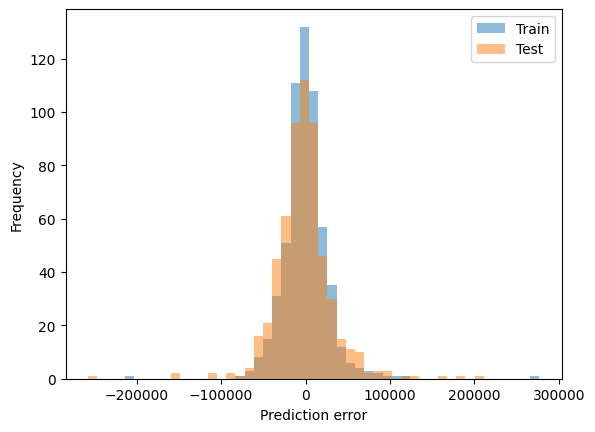

In [59]:
train_function, data, target = tasks['house_RF']
target_model, Xt_train, Xt_test, Xt_ext, yt_train, yt_test, yt_ext = train_function(data, target, n_est=400, max_d=4, ext_size=0.2)

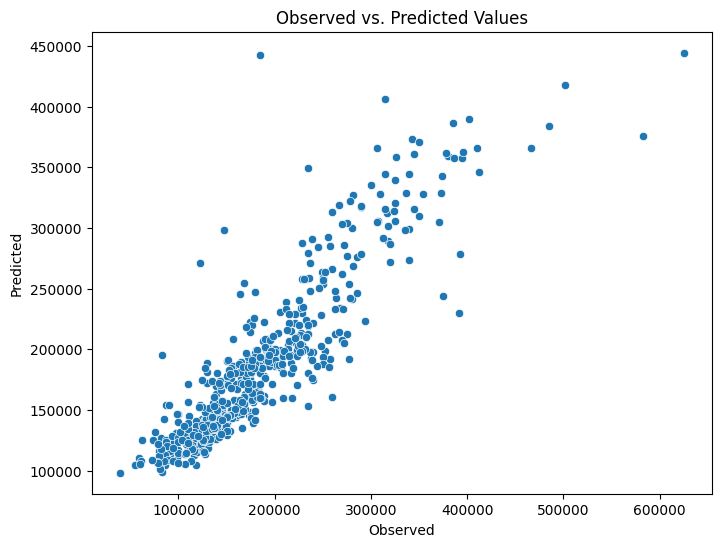

In [60]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=yt_test, y=target_model.predict(Xt_test))
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs. Predicted Values')
plt.show()

In [61]:
membership_true = np.concatenate((np.ones(len(yt_train)), np.zeros(len(yt_test))))

## Train Shadow models

In [62]:
train_function, data, target = tasks['house_RF']

Train set: RMSE = 29781.8412, Relative RMSE = 0.1636
Test set: RMSE = 35507.3513, Relative RMSE = 0.1963
Test R2 score = 0.7811
Overfit_percentage = 19.2248


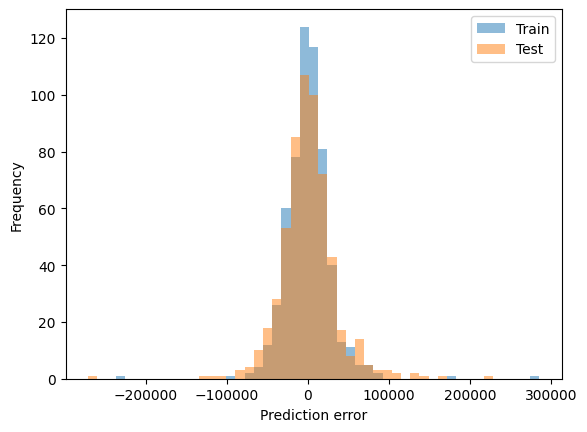

Train set: RMSE = 34496.9264, Relative RMSE = 0.1879
Test set: RMSE = 37516.2095, Relative RMSE = 0.2093
Test R2 score = 0.7380
Overfit_percentage = 8.7523


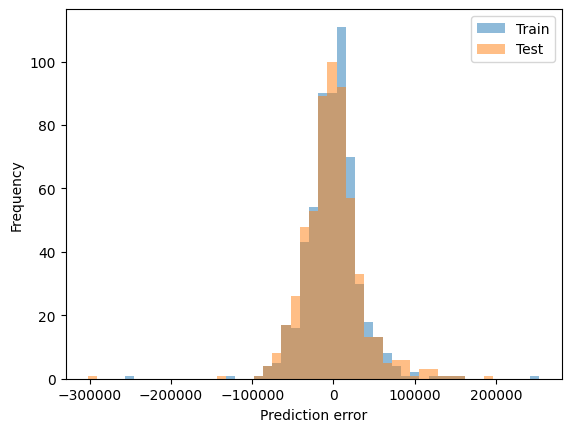

Train set: RMSE = 27045.6697, Relative RMSE = 0.1529
Test set: RMSE = 39050.3181, Relative RMSE = 0.2100
Test R2 score = 0.7748
Overfit_percentage = 44.3866


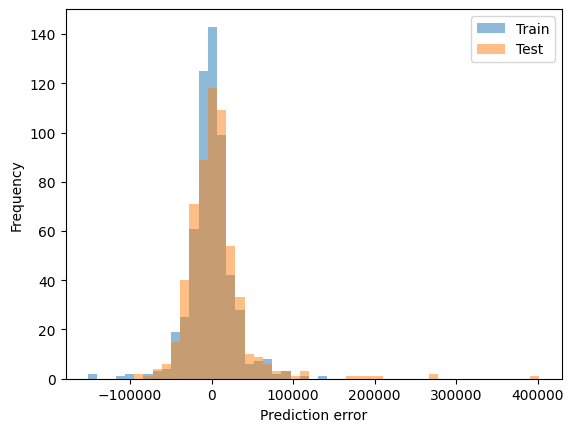

Train set: RMSE = 27017.1398, Relative RMSE = 0.1471
Test set: RMSE = 31366.6520, Relative RMSE = 0.1750
Test R2 score = 0.8313
Overfit_percentage = 16.0991


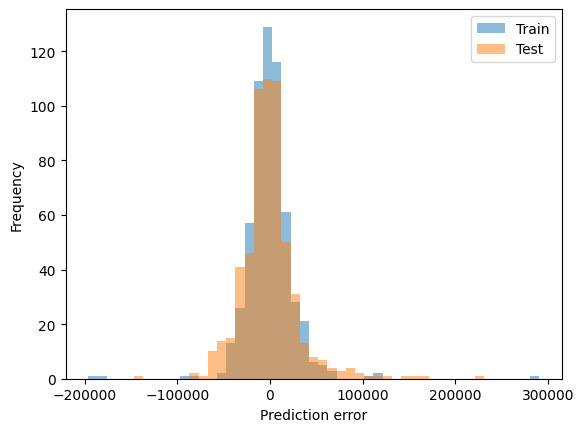

Train set: RMSE = 31763.8608, Relative RMSE = 0.1757
Test set: RMSE = 40831.9416, Relative RMSE = 0.2243
Test R2 score = 0.7001
Overfit_percentage = 28.5484


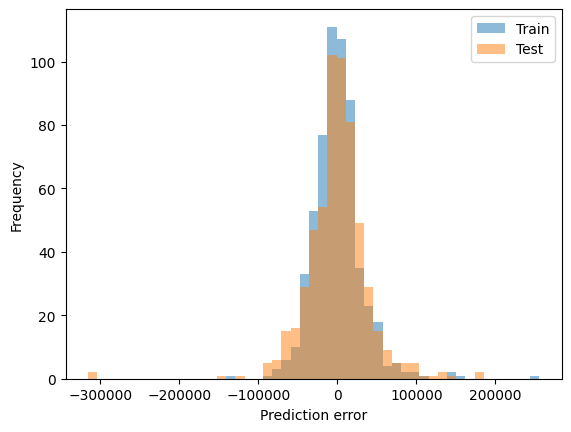

In [259]:
param_dicts = [
    {'n_est': 50, 'rand_stat': 1, 'max_d': 4},
    {'n_est': 200, 'rand_stat': 2, 'max_d': 3},
    {'n_est': 400, 'rand_stat': 3, 'max_d': 4},
    {'n_est': 100, 'rand_stat': 4, 'max_d': 5},
    {'n_est': 300, 'rand_stat': 5, 'max_d': 3},
    # add more parameter sets as needed
]

shadow_models, shadow_splits = train_shadow_models(train_function, data, target, param_dicts)

# **Check ART MIA Performance**

In [ ]:
from sklearn.linear_model import LinearRegression
from art.estimators.regression.scikitlearn import ScikitlearnRegressor

art_regressor = ScikitlearnRegressor(target_model)

print('Base model score: ', target_model.score(Xt_test, yt_test))

Base model score:  0.8401253819465637


In [ ]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

bb_attack = MembershipInferenceBlackBox(art_regressor, attack_model_type='gb', input_type='loss')

attack_train_ratio = 0.8
attack_train_size = int(len(Xt_train) * attack_train_ratio)
attack_test_size = int(len(Xt_test) * attack_train_ratio)

# train attack model
bb_attack.fit(Xt_train[:attack_train_size].to_numpy(copy=True), yt_train[:attack_train_size].to_numpy(copy=True),
              Xt_test[:attack_test_size].to_numpy(copy=True), yt_test[:attack_test_size].to_numpy(copy=True))

# infer
inferred_train_bb = bb_attack.infer(Xt_train[attack_train_size:].to_numpy(copy=True).astype(np.float32), yt_train[attack_train_size:].to_numpy(copy=True))
inferred_test_bb = bb_attack.infer(Xt_test[attack_test_size:].to_numpy(copy=True).astype(np.float32), yt_test[attack_test_size:].to_numpy(copy=True))

# check accuracy
train_acc_bb = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc_bb = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc_bb = (train_acc_bb * len(inferred_train_bb) + test_acc_bb * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print('Member accuracy:', train_acc_bb)
print('Non-Member accuracy:', test_acc_bb)
print('Accuracy:', acc_bb)

Member accuracy: 0.7948717948717948
Non-Member accuracy: 0.6153846153846154
Accuracy: 0.7051282051282052


In [ ]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

# rule-based
print(calc_precision_recall(np.concatenate((inferred_train_bb, inferred_test_bb)),
                            np.concatenate((np.ones(len(inferred_train_bb)), np.zeros(len(inferred_test_bb))))))

(0.6739130434782609, 0.7948717948717948)


# *MFMA Attack*

In [260]:
train_t_preds = target_model.predict(Xt_train)
test_t_preds = target_model.predict(Xt_test)

In [261]:
ext_preds = target_model.predict(Xt_ext)

In [262]:
train_s_preds_list = []
test_s_preds_list = []

for model, (X_train, X_test, _, _, _, _) in zip(shadow_models, shadow_splits):
    train_s_preds = model.predict(X_train)
    test_s_preds = model.predict(X_test)
    train_s_preds_list.append(train_s_preds)
    test_s_preds_list.append(test_s_preds)


In [ ]:
# if check_model_type(shadow_model_1) == 'XGBoost Model':
#    # Get feature importance
#    feature_importance_1 = shadow_model_1.get_booster().get_score(importance_type='weight')
#    feature_importance_2 = shadow_model_2.get_booster().get_score(importance_type='weight')
#    feature_importance_3 = shadow_model_3.get_booster().get_score(importance_type='weight')
# elif check_model_type(shadow_model_1) == 'Random Forest Model':
#    # For Random Forest and DT models
#    #feature_importance = shadow_model_1.feature_importances_
#    feature_names = Xt_train.columns  # Get feature names from DataFrame
#    feature_importance_1 = dict(zip(feature_names, shadow_model_1.feature_importances_))
#    feature_names_1 = X1_train.columns  # Get feature names from DataFrame
#    feature_importance_2 = dict(zip(feature_names_1, shadow_model_1.feature_importances_))
#    feature_names_2 = X2_train.columns  # Get feature names from DataFrame
#    feature_importance_2 = dict(zip(feature_names_2, shadow_model_2.feature_importances_))
#    feature_names_3 = X3_train.columns  # Get feature names from DataFrame
#    feature_importance_3 = dict(zip(feature_names_3, shadow_model_3.feature_importances_))

In [263]:
def extract_feature_importances(shadow_models, shadow_splits):
    """
    Computes and combines feature importances from multiple shadow models,
    supporting both XGBoost and Random Forest.

    Args:
        shadow_models: list of trained models (XGBoost or Random Forest).
        shadow_splits: list of (X_train, X_test, X_ext, y_train, y_test, y_ext) tuples.

    Returns:
        model_importances: list of pandas Series (one per model) with feature importances.
        combined_importance: pandas Series with mean importance across models.
    """
    model_importances = []

    for model, split in zip(shadow_models, shadow_splits):
        X_train = split[0]
        feature_names = X_train.columns

        model_type = check_model_type(model)

        if model_type == 'XGBoost Model':
            # XGBoost uses feature names like f0, f1...
            booster_scores = model.get_booster().get_score(importance_type='weight')
            scores = {f"f{idx}": booster_scores.get(f"f{idx}", 0.0) for idx in range(len(feature_names))}
            importance_series = pd.Series(scores.values(), index=feature_names)

        elif model_type == 'Random Forest Model':
            importance_series = pd.Series(model.feature_importances_, index=feature_names)

        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        model_importances.append(importance_series)

    combined_importance = pd.concat(model_importances, axis=1).mean(axis=1)

    return model_importances, combined_importance



In [264]:
model_importances, feature_importance_t = extract_feature_importances(shadow_models, shadow_splits)

# model_importances is a list: one Series per model
# feature_importance_t is the average of all models

In [ ]:
# if check_model_type(target_model) == 'XGBoost Model':
#   # Get feature importance
#   feature_importance = target_model.get_booster().get_score(importance_type='weight')
# else:
#   # For Random Forest and DT models
#   oob_preds = target_model.oob_prediction_
#   train_oob_diff = abs(oob_preds-train_preds)
#   oob_preds = target_model.oob_prediction_
#   test_oob_diff = abs(oob_preds-test_preds)
#   # Get feature importance
#   feature_importance = target_model.feature_importances_

#   # Sort the feature importance dictionary by values in descending order
#   sorted_feature_importance = np.argsort(feature_importance)[::-1]

#   first_feature_index = sorted_feature_importance[0]
#   second_feature_index = sorted_feature_importance[1]

In [265]:
train_t_errors = abs(train_t_preds - yt_train)
test_t_errors = abs(test_t_preds - yt_test)

In [266]:
ext_errors = abs(ext_preds - yt_ext)

In [267]:
train_s_errors_list = []
test_s_errors_list = []

for (train_preds, test_preds), (_, _, _, y_train, y_test, _) in zip(zip(train_s_preds_list, test_s_preds_list), shadow_splits):
    train_errors = abs(train_preds - y_train)
    test_errors = abs(test_preds - y_test)
    train_s_errors_list.append(train_errors)
    test_s_errors_list.append(test_errors)


In [268]:
augmented_records = 12

In [ ]:
#import shap

# Create an explainer using the trained model
#explainer = shap.Explainer(target_model)

In [269]:
features_t_means = Xt_train.mean()

In [270]:
features_s_means_list = []

for split in shadow_splits:
    X_train = split[0]  # X_train is the first element in the tuple
    features_s_means = X_train.mean()
    features_s_means_list.append(features_s_means)


In [271]:
import importlib
import processing  # This must be a full import, not just the function
importlib.reload(processing)  # Reloads the module
from processing import process_row  # Re-import updated function

In [272]:
def parallel_process_rows(X, feature_scale, model):

    #with multiprocessing.Pool() as pool:
    #    results = list(tqdm(pool.imap(process_row, [(index, row, feature_scale, target_model, augmented_records) for index, row in X.iterrows()]), total=len(X), desc="Processing rows"))

    #return results

    results = []
    for args in tqdm([(index, row, feature_scale, model, augmented_records) for index, row in X.iterrows()], total=len(X), desc="Processing rows"):
    #for args in [(index, row, 1, target_model, augmented_records) for index, row in X.iterrows()]:
      results.append(process_row(args))

    return results

In [273]:
num_processes = multiprocessing.cpu_count()  # Number of CPU cores
print(num_processes)

2


## Augmented set features

In [274]:
columns = ['index', 'aug_preds_var', 'aug_preds_range', 'aug_preds_diff'] + [f'aug_pred_{i}' for i in range(augmented_records)]

In [275]:
def rename_augmented_columns(df, noise_label):
    renamed = {}
    for col in df.columns:
        if col in ['aug_preds_diff', 'aug_preds_var', 'aug_preds_range']:
            renamed[col] = f'{col}_{noise_label}'
        elif col.startswith('aug_pred_'):
            pred_id = col.replace('aug_pred_', '')
            renamed[col] = f'aug_pred_{noise_label}_{pred_id}'
    return df.rename(columns=renamed)

In [276]:
def build_augmented_feature_dfs(shadow_models, shadow_splits, feature_scale, columns, noise_label):
    all_results = []

    for model_idx, (model, (X_train, X_test, *_)) in enumerate(zip(shadow_models, shadow_splits)):
        # Process train
        train_results = parallel_process_rows(X_train, feature_scale=feature_scale, model=model)
        train_df = pd.DataFrame(train_results, columns=columns)

        # Rename feature columns to include noise label
        train_df = rename_augmented_columns(train_df, noise_label)
        train_df['model_id'] = model_idx
        train_df['split'] = 'train'
        all_results.append(train_df)

        # Process test
        test_results = parallel_process_rows(X_test, feature_scale=feature_scale, model=model)
        test_df = pd.DataFrame(test_results, columns=columns)

        test_df = rename_augmented_columns(test_df, noise_label)
        test_df['model_id'] = model_idx
        test_df['split'] = 'test'
        all_results.append(test_df)

    return pd.concat(all_results, ignore_index=True)


### Feature Scale = 1

In [277]:
# Perform parallel processing
results = parallel_process_rows(Xt_train, feature_scale=1, model=target_model)
# Extract results maintaining original order
aug_train_t_1 = pd.DataFrame(results, columns=columns)
#index, augmented_train_t_stds_1, augmented_train_t_vars_1, augmented_train_t_range_1, augmented_train_t_diff_1, augmented_train_t_preds_1 = zip(*results)

# Perform parallel processing
results = parallel_process_rows(Xt_test, feature_scale=1, model=target_model)
# Extract results maintaining original order
aug_test_t_1 = pd.DataFrame(results, columns=columns)
#index, augmented_test_t_stds_1, augmented_test_t_vars_1, augmented_test_t_range_1, augmented_test_t_diff_1, augmented_test_t_preds_1 = zip(*results)

Processing rows: 100%|██████████| 584/584 [00:26<00:00, 22.24it/s]


In [278]:
results = parallel_process_rows(Xt_ext, feature_scale=1, model=target_model)
aug_ext_t_1 = pd.DataFrame(results, columns=columns)
#index, augmented_ext_stds_1, augmented_ext_vars_1, augmented_ext_range_1, augmented_ext_diff_1, augmented_ext_preds_1 = zip(*results)

Processing rows: 100%|██████████| 292/292 [00:13<00:00, 22.41it/s]


In [279]:
augmented_results_1 = build_augmented_feature_dfs(shadow_models, shadow_splits, feature_scale=1, columns=columns, noise_label='1')

Processing rows: 100%|██████████| 584/584 [00:20<00:00, 28.95it/s]


### Feature Scale = 0.1

In [280]:
# Perform parallel processing
results = parallel_process_rows(Xt_train, feature_scale=0.1, model=target_model)
# Extract results maintaining original order
aug_train_t_01 = pd.DataFrame(results, columns=columns)
#index, augmented_train_t_stds_01, augmented_train_t_vars_01, augmented_train_t_range_01, augmented_train_t_diff_01 = zip(*results)

# Perform parallel processing
results = parallel_process_rows(Xt_test, feature_scale=0.1, model=target_model)
# Extract results maintaining original order
aug_test_t_01 = pd.DataFrame(results, columns=columns)
#index, augmented_test_t_stds_01, augmented_test_t_vars_01, augmented_test_t_range_01, augmented_test_t_diff_01 = zip(*results)

Processing rows: 100%|██████████| 584/584 [00:25<00:00, 22.87it/s]


In [281]:
results = parallel_process_rows(Xt_ext, feature_scale=0.1, model=target_model)
aug_ext_t_01 = pd.DataFrame(results, columns=columns)
#index, augmented_ext_stds_01, augmented_ext_vars_01, augmented_ext_range_01, augmented_ext_diff_01 = zip(*results)

Processing rows: 100%|██████████| 292/292 [00:12<00:00, 22.78it/s]


In [282]:
augmented_results_01 = build_augmented_feature_dfs(shadow_models, shadow_splits, feature_scale=0.1, columns=columns, noise_label='01')

Processing rows: 100%|██████████| 584/584 [00:24<00:00, 23.95it/s]


### Feature Scale = 0.01

In [283]:
# Perform parallel processing
results = parallel_process_rows(Xt_train, feature_scale=0.01, model=target_model)
# Extract results maintaining original order
aug_train_t_001 = pd.DataFrame(results, columns=columns)
#index, augmented_train_t_stds_001, augmented_train_t_vars_001, augmented_train_t_range_001, augmented_train_t_diff_001 = zip(*results)

# Perform parallel processing
results = parallel_process_rows(Xt_test, feature_scale=0.01, model=target_model)
# Extract results maintaining original order
aug_test_t_001 = pd.DataFrame(results, columns=columns)
#index, augmented_test_t_stds_001, augmented_test_t_vars_001, augmented_test_t_range_001, augmented_test_t_diff_001 = zip(*results)

Processing rows: 100%|██████████| 584/584 [00:27<00:00, 20.97it/s]


In [284]:
results = parallel_process_rows(Xt_ext, feature_scale=0.01, model=target_model)
aug_ext_t_001 = pd.DataFrame(results, columns=columns)
#index, augmented_ext_stds_001, augmented_ext_vars_001, augmented_ext_range_001, augmented_ext_diff_001 = zip(*results)

Processing rows: 100%|██████████| 292/292 [00:14<00:00, 20.35it/s]


In [285]:
augmented_results_001 = build_augmented_feature_dfs(shadow_models, shadow_splits, feature_scale=0.01, columns=columns, noise_label='001')

Processing rows: 100%|██████████| 584/584 [00:22<00:00, 26.11it/s]


## Missing set features

In [286]:
def calculate_missing_stats(X_train, model, feature_importance, features_means, strategy='mean', n_important=3):
    """
    Calculates statistics (standard deviation, entropy, variance) of target model predictions
    on a dataset with strategically introduced missing values.

    Args:
        X_train (pd.DataFrame): The training dataset.
        target_model: The trained target model for prediction.
        feature_importance (pd.Series): Feature importance scores.
        features_means (pd.Series): Mean values of features.
        strategy (str, optional): Strategy for introducing missing values. Defaults to 'mean'.
        n_important (int, optional): Number of important features to consider. Defaults to 3.

    Returns:
        tuple: A tuple containing lists of standard deviations, entropies, and variances.
    """

    missing_train_stds = []
    missing_train_entropies = []
    missing_train_vars = []

    # Iterate over rows of X_train with tqdm
    for index, row in tqdm(X_train.iterrows(), total=len(X_train), desc="Processing rows"):
        # Function to create the set with missing values
        missing_set = create_missing_set(row, feature_importance, features_means, strategy, n_important)
        missing_set_df = pd.DataFrame(missing_set, columns=X_train.columns)

        # Predict the house price for modified set
        missing_set_preds = model.predict(missing_set_df)

        # Calculate statistics and store in their respective lists
        missing_train_stds.append(np.std(missing_set_preds))
        missing_train_entropies.append(entropy(missing_set_preds))
        missing_train_vars.append(np.var(missing_set_preds))

    return missing_train_stds, missing_train_entropies, missing_train_vars

In [287]:
my_strategy = 'mean'

In [288]:
missing_train_t_stds, missing_train_t_entropies, missing_train_t_vars = calculate_missing_stats(Xt_train, target_model, feature_importance_t, features_t_means, strategy=my_strategy, n_important=3)
missing_test_t_stds, missing_test_t_entropies, missing_test_t_vars = calculate_missing_stats(Xt_test, target_model, feature_importance_t, features_t_means, strategy=my_strategy, n_important=3)


Processing rows: 100%|██████████| 584/584 [00:29<00:00, 19.85it/s]


In [289]:
missing_ext_stds, missing_ext_entropies, missing_ext_vars = calculate_missing_stats(Xt_ext, target_model, feature_importance_t, features_t_means, strategy=my_strategy, n_important=3)

Processing rows: 100%|██████████| 292/292 [00:14<00:00, 19.87it/s]


In [290]:
missing_train_stats = []
missing_test_stats = []

for model, split, feat_importance, feat_means in zip(shadow_models, shadow_splits, model_importances, features_s_means_list):
    X_train, X_test = split[0], split[1]

    # Train set
    train_stats = calculate_missing_stats(
        X_train, model, feat_importance, feat_means,
        strategy=my_strategy, n_important=3
    )
    missing_train_stats.append(train_stats)

    # Test set
    test_stats = calculate_missing_stats(
        X_test, model, feat_importance, feat_means,
        strategy=my_strategy, n_important=3
    )
    missing_test_stats.append(test_stats)


Processing rows: 100%|██████████| 584/584 [00:22<00:00, 25.92it/s]


## XGB Estimators Variation

In [2]:
def compute_estimators_metrics(model, X_data, alpha=0.01, window_prcnt=0.1):
    """
    Computes per-record tree contribution metrics for XGBRegressor:
    - Ratio of positive vs. negative contributions
    - Standard deviation of contributions
    - Direction consistency (how many trees contributed in same direction)
    - Convergence point of prediction

    Parameters:
        model (xgb.XGBRegressor): Trained model
        X_data (pd.DataFrame or np.array): Input data
        alpha (float): Convergence sensitivity threshold

    Returns:
        Tuple of lists: (std_contribs, directional_consistencies, convergence_indexs)
    """
    booster = model.get_booster()
    num_trees = booster.num_boosted_rounds()
    std_contribs = []
    directional_consistencies = []
    convergence_indexs = []

    for i in tqdm(range(len(X_data)), desc="Computing metrics"):
        dmatrix = xgb.DMatrix(X_data.iloc[[i]] if isinstance(X_data, pd.DataFrame) else X_data[i:i+1])

        predictions = np.array([
            booster.predict(dmatrix, iteration_range=(0, t + 1))[0]
            for t in range(num_trees)
        ])

        contributions = np.diff(predictions, prepend=0)
        num_pos = np.sum(contributions > 0)
        num_neg = np.sum(contributions < 0)

        pos_ratio = num_pos / num_trees
        neg_ratio = num_neg / num_trees
        std_contrib = np.std(contributions)
        directional_consistency = max(num_pos, num_neg) / num_trees

        final_pred = predictions[-1]
        threshold = alpha * abs(final_pred) if final_pred != 0 else alpha

        # הפרשים בין תחזיות עוקבות
        diffs = np.abs(np.diff(predictions))

        # חפש רצף של window צעדים בהם כל ההפרשים קטנים מהסף
        window = int(window_prcnt * num_trees)
        converged = False
        for t in range(num_trees - window):
            if np.all(diffs[t:t+window] < threshold):
                convergence_ratio = (t + 1) / num_trees  # +1 כי diff מתחיל אחרי העץ הראשון
                converged = True
                break
        if not converged:
            convergence_ratio = 1.0

        std_contribs.append(std_contrib)
        directional_consistencies.append(directional_consistency)
        convergence_indexs.append(convergence_ratio)

    return std_contribs, directional_consistencies, convergence_indexs


In [ ]:
trees_train_t_stds, trees_train_t_directionallity, trees_train_t_conv_idx = compute_estimators_metrics(target_model, Xt_train)
trees_test_t_stds, trees_test_t_directionallity, trees_test_t_conv_idx = compute_estimators_metrics(target_model, Xt_test)

Computing metrics: 100%|██████████| 584/584 [00:59<00:00,  9.83it/s]


In [ ]:
XGB_train_metrics = []
XGB_test_metrics = []

for model, split in zip(shadow_models, shadow_splits):
    X_train, X_test = split[0], split[1]

    # Train metrics
    train_metrics = compute_estimators_metrics(model, X_train)
    XGB_train_metrics.append(train_metrics)

    # Test metrics
    test_metrics = compute_estimators_metrics(model, X_test)
    XGB_test_metrics.append(test_metrics)

### XGB_Trees_analisys

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

def plot_prediction_trajectory(model, X_data, index=0):
    """
    מציג גרף של התחזית בכל מחזור (עץ) עבור רשומה בודדת.

    Parameters:
        model (xgb.XGBRegressor): המודל המאומן
        X_data (pd.DataFrame or np.array): הנתונים
        index (int): אינדקס של הרשומה להצגה
    """
    booster = model.get_booster()
    num_trees = booster.num_boosted_rounds()

    sample = X_data.iloc[[index]] if isinstance(X_data, pd.DataFrame) else X_data[index:index+1]
    dmatrix = xgb.DMatrix(sample)

    predictions = np.array([
        booster.predict(dmatrix, iteration_range=(0, t + 1))[0]
        for t in range(num_trees)
    ])

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_trees + 1), predictions, marker='o', linestyle='-', color='steelblue')
    plt.title(f'Prediction Trajectory for Sample #{index}')
    plt.xlabel('Tree Index')
    plt.ylabel('Prediction')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


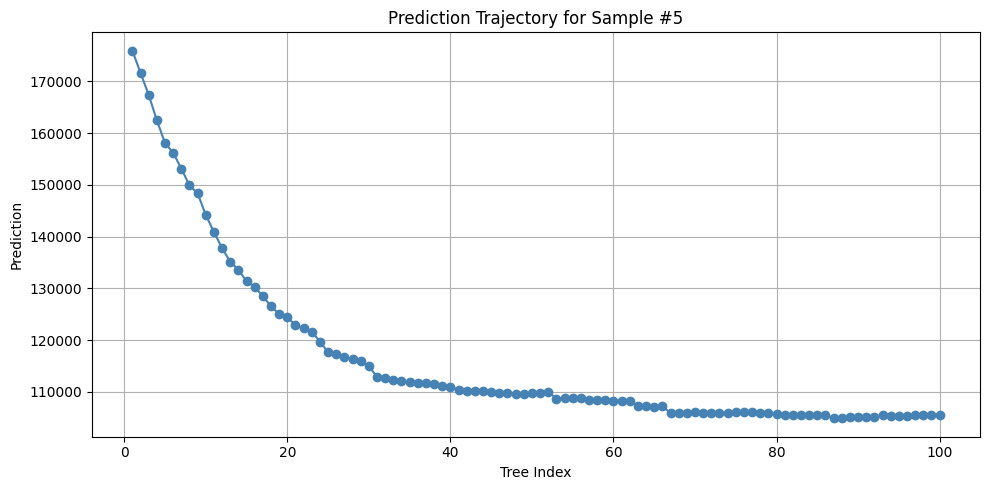

In [ ]:
plot_prediction_trajectory(target_model, Xt_test, index=5)

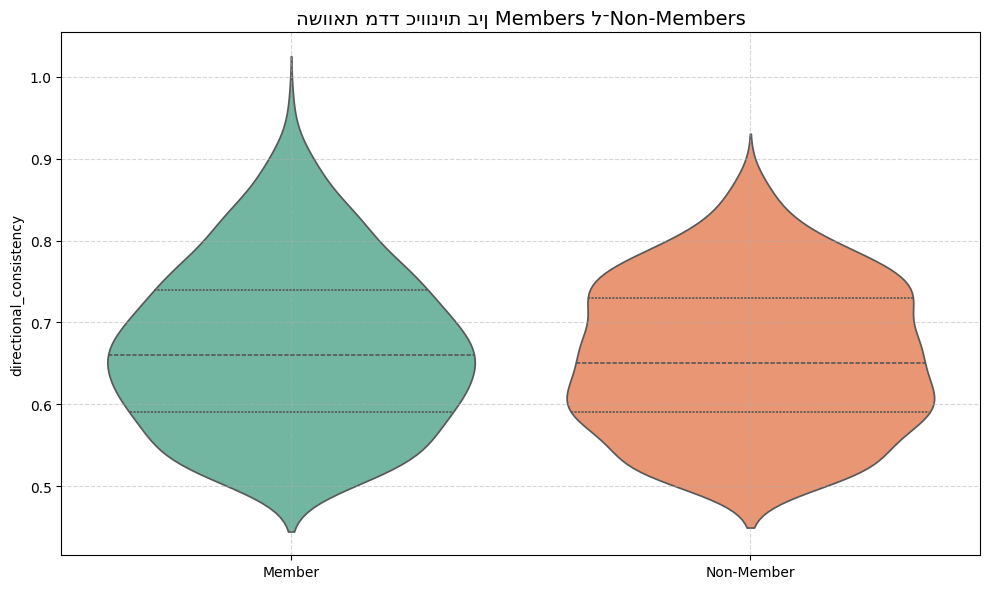

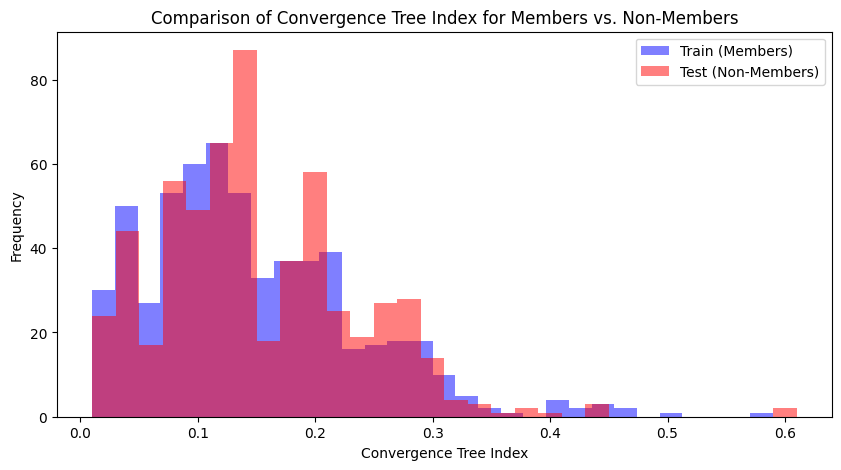

In [ ]:
# # Extract the positive_contrib_ratio values for train and test sets
# train_positive_contrib_ratios = [metric["positive_contrib_ratio"] for metric in train_metrics]
# test_positive_contrib_ratios = [metric["positive_contrib_ratio"] for metric in test_metrics]

# # 📊 Plot comparison of positive contribution ratio
# plt.figure(figsize=(10, 5))
# # Use the extracted values for plotting
# plt.hist(train_positive_contrib_ratios, bins=30, alpha=0.5, label="Train (Members)", color="blue")
# plt.hist(test_positive_contrib_ratios, bins=30, alpha=0.5, label="Test (Non-Members)", color="red")
# plt.xlabel("Positive Contribution Ratio")
# plt.ylabel("Frequency")
# plt.title("Comparison of Positive Contribution Ratio for Members vs. Non-Members")
# plt.legend()
# plt.show()


# הוספת תווית של קבוצה
train_df = pd.DataFrame(trees_train_t_directionallity, columns=["directional_consistency"])
train_df["group"] = "Member"

test_df = pd.DataFrame(trees_test_t_directionallity, columns=["directional_consistency"])
test_df["group"] = "Non-Member"

combined_df = pd.concat([train_df, test_df], ignore_index=True)

# ציור
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_df, x="group", y="directional_consistency", inner="quartile", palette="Set2")
plt.title("השוואת מדד כיווניות בין Members ל־Non-Members", fontsize=14)
plt.ylabel("directional_consistency")
plt.xlabel("")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 📊 Plot comparison of convergence tree index
plt.figure(figsize=(10, 5))
# Use the extracted values for plotting
plt.hist(trees_train_t_conv_idx, bins=30, alpha=0.5, label="Train (Members)", color="blue")
plt.hist(trees_test_t_conv_idx, bins=30, alpha=0.5, label="Test (Non-Members)", color="red")
plt.xlabel("Convergence Tree Index")
plt.ylabel("Frequency")
plt.title("Comparison of Convergence Tree Index for Members vs. Non-Members")
plt.legend()
plt.show()

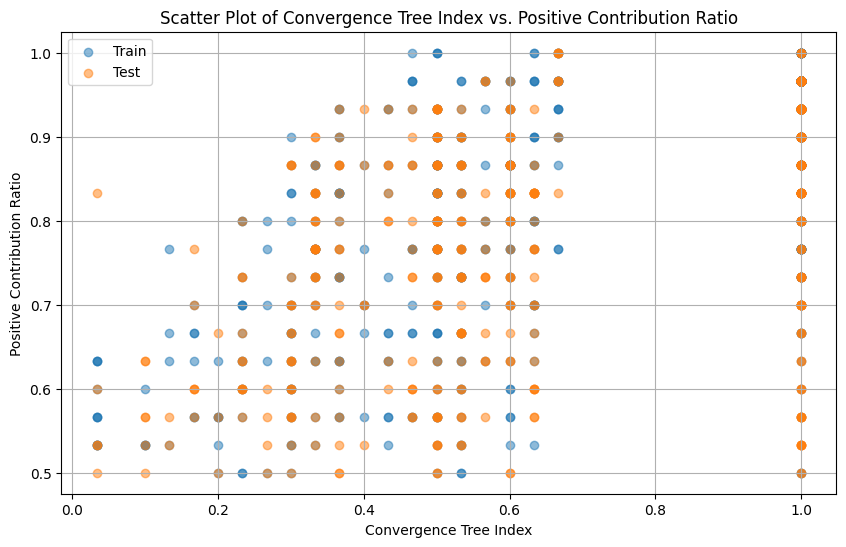

In [ ]:
# prompt: create scatter plot consist of convergance tree index and positive contribution ratio

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(trees_train_t_conv_idx, trees_train_t_directionallity, label="Train", alpha=0.5)
plt.scatter(trees_test_t_conv_idx, trees_test_t_directionallity, label="Test", alpha=0.5)

plt.xlabel("Convergence Tree Index")
plt.ylabel("Positive Contribution Ratio")
plt.title("Scatter Plot of Convergence Tree Index vs. Positive Contribution Ratio")
plt.legend()
plt.grid(True)
plt.show()


## RF trees features

In [291]:
def calculate_tree_stats(model, X):
    """
    Calculates statistics (standard deviation, entropy, variance) of predictions
    from individual trees in an ensemble model.

    Args:
        model: The trained ensemble model (e.g., RandomForestRegressor).
        X (pd.DataFrame): The dataset to predict on.

    Returns:
        tuple: A tuple containing lists of standard deviations, entropies, and variances.
    """

    # Get predictions from individual trees
    tree_predictions = np.array([tree.predict(X) for tree in model.estimators_])

    # Calculate statistics across predictions for each sample
    stds = np.std(tree_predictions, axis=0)
    vars_ = np.var(tree_predictions, axis=0)
    entropies = entropy(tree_predictions)

    return stds, vars_, entropies

In [292]:
trees_train_t_stds, trees_train_t_vars, trees_train_t_entropies = calculate_tree_stats(target_model, Xt_train)
trees_test_t_stds, trees_test_t_vars, trees_test_t_entropies = calculate_tree_stats(target_model, Xt_test)

In [293]:
RF_train_metrics = []
RF_test_metrics = []

for model, split in zip(shadow_models, shadow_splits):
    X_train, X_test = split[0], split[1]

    # Train set metrics
    train_metrics = calculate_tree_stats(model, X_train)
    RF_train_metrics.append(train_metrics)

    # Test set metrics
    test_metrics = calculate_tree_stats(model, X_test)
    RF_test_metrics.append(test_metrics)


## Attack

In [294]:
# Initialize base features
data_attack_dict = {
    'prediction': [],
    'error': [],
    'membership': [],
    'missing_preds_entropies': [],
    'missing_preds_vars': []
}

# Conditionally add model-specific features
model_type = check_model_type(shadow_models[0])

if model_type == 'XGBoost Model':
    data_attack_dict['XGB_trees_directionallity'] = []
    data_attack_dict['XGB_trees_conv_idx'] = []
elif model_type == 'Random Forest Model':
    data_attack_dict['RF_trees_vars'] = []
    data_attack_dict['RF_trees_entropies'] = []

# Fill base values
for i in range(len(shadow_models)):
    data_attack_dict['prediction'] += list(train_s_preds_list[i]) + list(test_s_preds_list[i])
    data_attack_dict['error'] += list(train_s_errors_list[i]) + list(test_s_errors_list[i])
    data_attack_dict['missing_preds_entropies'] += list(missing_train_stats[i][1]) + list(missing_test_stats[i][1])
    data_attack_dict['missing_preds_vars'] += list(missing_train_stats[i][2]) + list(missing_test_stats[i][2])

    if model_type == 'XGBoost Model':
        data_attack_dict['XGB_trees_directionallity'] += list(XGB_train_metrics[i][1]) + list(XGB_test_metrics[i][1])
        data_attack_dict['XGB_trees_conv_idx'] += list(XGB_train_metrics[i][2]) + list(XGB_test_metrics[i][2])
    elif model_type == 'Random Forest Model':
        data_attack_dict['RF_trees_vars'] += list(RF_train_metrics[i][1]) + list(RF_test_metrics[i][1])
        data_attack_dict['RF_trees_entropies'] += list(RF_train_metrics[i][2]) + list(RF_test_metrics[i][2])

    y_train = shadow_splits[i][3]
    y_test = shadow_splits[i][4]
    data_attack_dict['membership'] += list(np.ones(len(y_train))) + list(np.zeros(len(y_test)))

In [295]:
# Assume these are already concatenated with renamed columns
# and aligned with the rest of the data:
# augmented_results_1, augmented_results_01, augmented_results_001

for df in [augmented_results_1, augmented_results_01, augmented_results_001]:
    for col in df.columns:
        if col not in ['index', 'model_id', 'split']:  # skip meta
            data_attack_dict[col] = list(df[col])


In [296]:
# Start with the shared base features
data_test_dict = {
    'prediction': list(train_t_preds) + list(test_t_preds),
    'error': list(train_t_errors) + list(test_t_errors),

    # Membership labels
    'membership': list(np.ones(len(yt_train))) + list(np.zeros(len(yt_test))),

    # Missing features
    'missing_preds_entropies': list(missing_train_t_entropies) + list(missing_test_t_entropies),
    'missing_preds_vars': list(missing_train_t_vars) + list(missing_test_t_vars),

    # Augmented scalar features
    'aug_preds_range_1': list(aug_train_t_1['aug_preds_range']) + list(aug_test_t_1['aug_preds_range']),
    'aug_preds_var_1': list(aug_train_t_1['aug_preds_var']) + list(aug_test_t_1['aug_preds_var']),
    'aug_preds_diff_1': list(aug_train_t_1['aug_preds_diff']) + list(aug_test_t_1['aug_preds_diff']),
    'aug_preds_range_01': list(aug_train_t_01['aug_preds_range']) + list(aug_test_t_01['aug_preds_range']),
    'aug_preds_var_01': list(aug_train_t_01['aug_preds_var']) + list(aug_test_t_01['aug_preds_var']),
    'aug_preds_diff_01': list(aug_train_t_01['aug_preds_diff']) + list(aug_test_t_01['aug_preds_diff']),
    'aug_preds_range_001': list(aug_train_t_001['aug_preds_range']) + list(aug_test_t_001['aug_preds_range']),
    'aug_preds_var_001': list(aug_train_t_001['aug_preds_var']) + list(aug_test_t_001['aug_preds_var']),
    'aug_preds_diff_001': list(aug_train_t_001['aug_preds_diff']) + list(aug_test_t_001['aug_preds_diff'])
}

# Map each (train_df, test_df) to its corresponding noise label
aug_dfs = [
    (aug_train_t_1, aug_test_t_1, '1'),
    (aug_train_t_01, aug_test_t_01, '01'),
    (aug_train_t_001, aug_test_t_001, '001')
]

# Add all prediction features with renamed columns
for aug_train_df, aug_test_df, noise_label in aug_dfs:
    for col in aug_train_df.columns:
        if col.startswith('aug_pred_'):
            # Extract the number from 'aug_pred_0' → '0'
            col_suffix = col.replace('aug_pred_', '')
            new_col = f'aug_pred_{noise_label}_{col_suffix}'
            data_test_dict[new_col] = list(aug_train_df[col]) + list(aug_test_df[col])

# Check model type
target_model_type = check_model_type(target_model)  # You should define `target_model` or whatever holds it

# Conditionally add model-specific metrics
if target_model_type == 'XGBoost Model':
    data_test_dict['XGB_trees_directionallity'] = list(trees_train_t_directionallity) + list(trees_test_t_directionallity)
    data_test_dict['XGB_trees_conv_idx'] = list(trees_train_t_conv_idx) + list(trees_test_t_conv_idx)

elif target_model_type == 'Random Forest Model':
    data_test_dict['RF_trees_vars'] = list(trees_train_t_vars) + list(trees_test_t_vars)
    data_test_dict['RF_trees_entropies'] = list(trees_train_t_entropies) + list(trees_test_t_entropies)


In [297]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

def build_both_dataframes(feature_keys, data_attack_dict, data_test_dict):
    def check_lengths(data_dict, label):
        lengths = {key: len(data_dict[key]) for key in feature_keys}
        unique_lengths = set(lengths.values())
        if len(unique_lengths) > 1:
            print(f"❌ Length mismatch in {label}:")
            for k, v in lengths.items():
                print(f"  {k}: {v} rows")
            raise ValueError(f"Inconsistent lengths found in {label}")
        return pd.DataFrame({key: data_dict[key] for key in feature_keys})

    df_attack = check_lengths(data_attack_dict, "data_attack")
    df_test = check_lengths(data_test_dict, "data_test")
    return df_attack, df_test


def launch_group_column_selector(data_attack_dict, data_test_dict, title="Grouped Feature Selector"):
    all_keys = set(data_attack_dict.keys()) & set(data_test_dict.keys())

    # Define groups
    used_keys = set()
    group_defs = {
        "Basic": ['prediction', 'error', 'membership'],
        "Missing": [k for k in all_keys if 'missing' in k],
        "Aug. Range": [k for k in all_keys if 'aug_preds_range' in k],
        "Aug. Vars": [k for k in all_keys if 'aug_preds_var' in k],
        "Aug. Diffs": [k for k in all_keys if 'aug_preds_diff' in k],
        "Aug. Preds 1": [k for k in all_keys if k.startswith('aug_pred_1')],
        "Aug. Preds 01": [k for k in all_keys if k.startswith('aug_pred_01')],
        "Aug. Preds 001": [k for k in all_keys if k.startswith('aug_pred_001')],
        "XGB Trees": [k for k in all_keys if 'XGB' in k],
        "RF Trees": [k for k in all_keys if 'RF' in k]
    }

    for v in group_defs.values():
        used_keys.update(v)
    #group_defs["Other"] = sorted(all_keys - used_keys)

    group_columns = []
    all_feature_checkboxes = []

    feature_count_label = widgets.Label()

    def update_feature_count(_=None):
        selected = [cb.description for cb in all_feature_checkboxes if cb.value]
        feature_count_label.value = f"{len(selected)} feature(s) selected"

    for group_name, features in group_defs.items():
        # Header label
        header = widgets.HTML(value=f"<b>{group_name}</b>")

        # Feature checkboxes
        checkboxes = [
            widgets.Checkbox(value=(f in ['prediction', 'error', 'membership']), description=f, indent=False)
            for f in features
        ]
        all_feature_checkboxes.extend(checkboxes)

        # Group-level select all toggle
        select_all = widgets.Checkbox(value=False, description='Select All', indent=False)

        def toggle_group(select_all_box, group_checkboxes):
            def toggle(change):
                if change['name'] == 'value':
                    for cb in group_checkboxes:
                        cb.value = change['new']
            return toggle

        select_all.observe(toggle_group(select_all, checkboxes))

        # Vertical layout for this group (header, group toggle, checkboxes)
        col_box = widgets.VBox([header, select_all] + checkboxes, layout=widgets.Layout(align_items='flex-start'))
        group_columns.append(col_box)

        # Observe checkbox changes to update count
        for cb in checkboxes:
            cb.observe(update_feature_count, names='value')

    # Horizontal layout
    column_layout = widgets.HBox(group_columns, layout=widgets.Layout(overflow='auto'))

    # Build button and output
    build_button = widgets.Button(description="Build DataFrames", button_style='success')
    output = widgets.Output()

    def on_build_clicked(b):
        with output:
            clear_output()
            selected = [cb.description for cb in all_feature_checkboxes if cb.value]
            if not selected:
                print("⚠️ Please select at least one feature.")
                return
            global data_attack, data_test
            data_attack, data_test = build_both_dataframes(selected, data_attack_dict, data_test_dict)
            print("✅ Preview: data_attack")
            display(data_attack.head())
            print("✅ Preview: data_test")
            display(data_test.head())

    build_button.on_click(on_build_clicked)
    update_feature_count()

    # Final display
    display(widgets.VBox([
        widgets.HTML(f"<h3>{title}</h3>"),
        column_layout,
        feature_count_label,
        build_button,
        output
    ]))


In [298]:
launch_group_column_selector(data_attack_dict, data_test_dict)

## Train Inference model with Hold-out data

the following data_attack aims to train the inference model with non-members which are based on th hold-out data

In [ ]:
# data_attack = pd.DataFrame({#'prediction': list(train_1_preds)+list(test_1_preds)+list(train_2_preds)+list(test_2_preds)+list(train_3_preds)+list(test_3_preds),
#                             'error': list(train_1_errors) + list(ext_errors) + list(train_2_errors) + list(ext_errors) + list(train_3_errors) + list(ext_errors),
#                             'missing_preds_entropies': list(missing_train_1_entropies)+list(missing_ext_entropies)+list(missing_train_2_entropies)+list(missing_ext_entropies)+list(missing_train_3_entropies)+list(missing_ext_entropies),
#                             'missing_preds_vars': list(missing_train_1_vars)+list(missing_ext_vars)+list(missing_train_2_vars)+list(missing_ext_vars)+list(missing_train_3_vars)+list(missing_ext_vars),
#                             # 'augmented_preds_entropies_1': list(augmented_train_1_entropies_1)+list(augmented_ext_entropies_1)+list(augmented_train_2_entropies_1)+list(augmented_ext_entropies_1)+list(augmented_train_3_entropies_1)+list(augmented_ext_entropies_1),
#                             # 'augmented_preds_entropies_01': list(augmented_train_1_entropies_01)+list(augmented_ext_entropies_01)+list(augmented_train_2_entropies_01)+list(augmented_ext_entropies_01)+list(augmented_train_3_entropies_01)+list(augmented_ext_entropies_01),
#                             # 'augmented_preds_entropies_001': list(augmented_train_1_entropies_001)+list(augmented_ext_entropies_001)+list(augmented_train_2_entropies_001)+list(augmented_ext_entropies_001)+list(augmented_train_3_entropies_001)+list(augmented_ext_entropies_001),
#                             # 'augmented_preds_vars_1': list(augmented_train_1_vars_1)+list(augmented_ext_vars_1)+list(augmented_train_2_vars_1)+list(augmented_ext_vars_1)+list(augmented_train_3_vars_1)+list(augmented_ext_vars_1),
#                             # 'augmented_preds_vars_01': list(augmented_train_1_vars_01)+list(augmented_ext_vars_01)+list(augmented_train_2_vars_01)+list(augmented_ext_vars_01)+list(augmented_train_3_vars_01)+list(augmented_ext_vars_01),
#                             # 'augmented_preds_vars_001': list(augmented_train_1_vars_001)+list(augmented_ext_vars_001)+list(augmented_train_2_vars_001)+list(augmented_ext_vars_001)+list(augmented_train_3_vars_001)+list(augmented_ext_vars_001),
#                              'augmented_preds_diff_1': list(augmented_train_1_diff_1)+list(augmented_ext_diff_1)+list(augmented_train_2_diff_1)+list(augmented_ext_diff_1)+list(augmented_train_3_diff_1)+list(augmented_ext_diff_1),
#                              'augmented_preds_diff_01': list(augmented_train_1_diff_01)+list(augmented_ext_diff_01)+list(augmented_train_2_diff_01)+list(augmented_ext_diff_01)+list(augmented_train_3_diff_01)+list(augmented_ext_diff_01),
#                              'augmented_preds_diff_001': list(augmented_train_1_diff_001)+list(augmented_ext_diff_001)+list(augmented_train_2_diff_001)+list(augmented_ext_diff_001)+list(augmented_train_3_diff_001)+list(augmented_ext_diff_001),
#                             # 'trees_vars': list(trees_train_1_vars)+list(trees_test_1_vars)+list(trees_train_2_vars)+list(trees_test_2_vars)+list(trees_train_3_vars)+list(trees_test_3_vars),
#                             # 'trees_entropies': list(trees_train_1_entropies)+list(trees_test_1_entropies)+list(trees_train_2_entropies)+list(trees_test_2_entropies)+list(trees_train_3_entropies)+list(trees_test_3_entropies),
#                             #'augmented_preds_entropies_001': list(augmented_train_entropies_001)+list(augmented_test_entropies_001),
#                             #'oob_diff': list(train_oob_diff) + list(test_oob_diff),
#                             'membership': list(np.ones(len(y1_train))) + list(np.zeros(len(yt_ext))) + list(np.ones(len(y2_train))) + list(np.zeros(len(yt_ext))) + list(np.ones(len(y3_train))) + list(np.zeros(len(yt_ext)))})

In [ ]:
# data_ext = pd.DataFrame({#'prediction': list(train_t_preds)+list(test_t_preds),
#                             'error': list(train_t_errors) + list(ext_errors),
#                             'missing_preds_entropies': list(missing_train_t_entropies)+list(missing_ext_entropies),
#                             'missing_preds_vars': list(missing_train_t_vars)+list(missing_ext_vars),
#                             # 'augmented_preds_entropies_1': list(augmented_train_t_entropies_1)+list(augmented_ext_entropies_1),
#                             # 'augmented_preds_entropies_01': list(augmented_train_t_entropies_01)+list(augmented_ext_entropies_01),
#                             # 'augmented_preds_entropies_001': list(augmented_train_t_entropies_001)+list(augmented_ext_entropies_001),
#                             # 'augmented_preds_vars_1': list(augmented_train_t_vars_1)+list(augmented_ext_vars_1),
#                             # 'augmented_preds_vars_01': list(augmented_train_t_vars_01)+list(augmented_ext_vars_01),
#                             # 'augmented_preds_vars_001': list(augmented_train_t_vars_001)+list(augmented_ext_vars_001),
#                             'augmented_preds_diff_1': list(augmented_train_t_diff_1)+list(augmented_ext_diff_1),
#                             'augmented_preds_diff_01': list(augmented_train_t_diff_01)+list(augmented_ext_diff_01),
#                             'augmented_preds_diff_001': list(augmented_train_t_diff_001)+list(augmented_ext_diff_001),
#                             # 'trees_vars': list(trees_train_t_vars)+list(trees_ext_vars),
#                             # 'trees_entropies': list(trees_train_t_entropies)+list(trees_ext_entropies),
#                             #'augmented_preds_entropies_001': list(augmented_train_entropies_001)+list(augmented_test_entropies_001),
#                             #'oob_diff': list(train_oob_diff) + list(test_oob_diff),
#                             'membership': list(np.ones(len(yt_train))) + list(np.zeros(len(yt_ext)))})

In [ ]:
# data_attack

## Train Inference Model

In [ ]:
data_attack.replace([np.inf, -np.inf], 0, inplace=True)
data_test.replace([np.inf, -np.inf], 0, inplace=True)

X_attack = data_attack.drop('membership', axis=1)
y_attack = data_attack['membership']

Xt_attack_test = data_test.drop('membership', axis=1)
yt_attack_test = data_test['membership']

X_train_att, X_test_att, y_train_att, y_test_att = train_test_split(X_attack, y_attack, test_size=0.1, stratify=y_attack, random_state=42)
#Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
clf = xgb.XGBClassifier(colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample= 0.8, n_estimators=400, random_state=42)

clf.fit(X_train_att, y_train_att)

In [300]:
# X_attack_ext = data_ext.drop('membership', axis=1)
# y_attack_ext = data_ext['membership']

In [305]:
X_train_att, X_test_att, y_train_att, y_test_att = train_test_split(X_attack, y_attack, test_size=0.1, stratify=y_attack, random_state=42)

#Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
clf = xgb.XGBClassifier(colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample= 0.8, n_estimators=400, random_state=42)

clf.fit(X_train_att, y_train_att)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

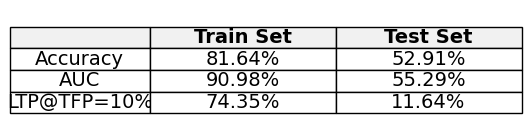

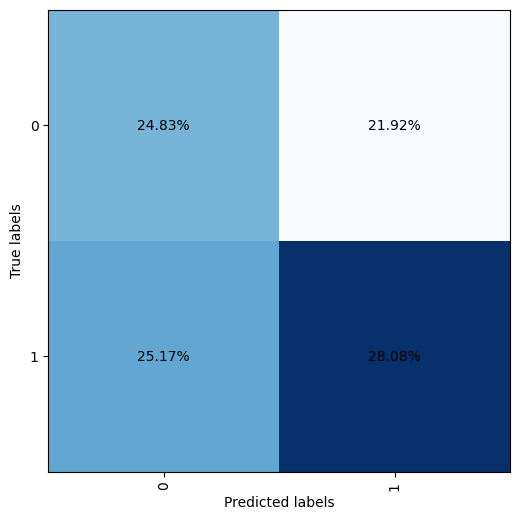

In [306]:
pred_train_att = clf.predict(X_train_att)
pred_test_att = clf.predict(X_test_att)
proba_train_att = clf.predict_proba(X_train_att)[:, 1]
proba_test_att = clf.predict_proba(X_test_att)[:, 1]
plot_train_test_metrics(y_train_att, pred_train_att, proba_train_att, y_test_att, pred_test_att, proba_test_att)
plot_metrics(pred_test_att, y_test_att)

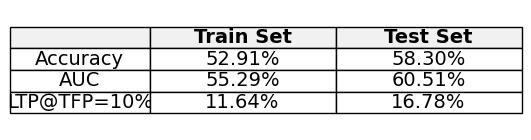

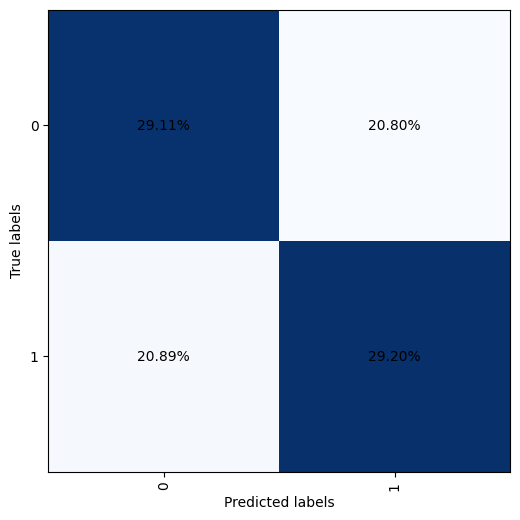

In [307]:
pred_train_att = clf.predict(X_test_att)
pred_test_att = clf.predict(Xt_attack_test)
proba_train_att = clf.predict_proba(X_test_att)[:, 1]
proba_test_att = clf.predict_proba(Xt_attack_test)[:, 1]
plot_train_test_metrics(y_test_att, pred_train_att, proba_train_att, yt_attack_test, pred_test_att, proba_test_att)
plot_metrics(pred_test_att, yt_attack_test)